<a href="https://colab.research.google.com/github/heejjj/Sleeping_Project/blob/main/%5Bfix%5DDeep_Learning_for_ECG_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper: Deep learning for ECG segmentation

- Moskalenko, Viktor, Nikolai Zolotykh, and Grigory Osipov. "Deep learning for ECG segmentation." International conference on neuroinformatics. Springer, Cham, 2019.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install scipy
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# /content/drive/MyDrive/KDT_project/[ECGsegmentation]230516/ecg_data_200.json

### 00. 필요한 라이브러리 임포트

In [ ]:
import numpy as np
import tensorflow as tf

# 데이터 전처리를 위한 라이브러리
import json
from scipy.signal import butter, lfilter, medfilt   # 심전도 데이터 노이즈를 제거하기 위해.

# 모델 학습을 위한 라이브러리
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import Conv1DTranspose, concatenate, Activation, SpatialDropout1D

# 성능평가 함수를 위한 라이브러리
from tensorflow.keras import backend as K

# 시각화를 위한 라이브러리. 전처리가 잘 되었는지 결과를 확인하기 위함.
from tqdm import tqdm
import matplotlib.pyplot as plt

### 01. 데이터 불러오기

In [ ]:
# 변수 정의하기
# variables
leads_names = ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']  # ECG
FREQUENCY_OF_DATASET = 500   # 샘플링 주파수.

num_classes = 4 # P, qrs, t, background

leads = 12   # 채널 개수.

In [ ]:
"""
Code Source
https://github.com/Namenaro/ecg_segmentation
(Paper : ECG Segmentation by Neural Networks : Errors and Correction)

Read LUDB dataset (json file)
"""
def load_raw_dataset(raw_dataset):
    '''
    1. 입력 변수
        raw_dataset: 데이터 셋이 들어옵니다.
    
    2. 출력 변수
        데이터라벨링이 끝나면, 넘파이 배열로 만들어 준 후, array의 1축과 2축의 위치를 바꾸어 준다.
        마지막으로 딕셔너리의 형태로 데이터와 마스크를 리턴한다.
        
    3. 데이터를 불러오는 함수입니다.
    '''
    with open(raw_dataset, 'r') as f:  # 읽기(r) 모드로 json 파일을 읽어옴.
        data = json.load(f)
    X=[]
    Y=[]
    for case_id in data.keys():
        leads = data[case_id]['Leads']   # 딕셔너리 key  인 'Leads'를 가져옴.
        x = []
        y = []
        for i in range(len(leads_names)):   # for 문을 통해서 Lead 별로 심전도 데이터를 가져오겠다.
            lead_name = leads_names[i]
            tmp = leads[lead_name]['Signal']   # 'Signal' key를 가져오면 각 Leads에 대한 심전도 데이터를 가져옴. 
            tmp = np.asarray(tmp, dtype=np.float64)
            tmp = tmp / 1000. # -> scaling 이유: 정규화 (단위 변경: mV --> uV)   # 단위가 천 단위임. scaling을 통해 계산 범위를 줄여줌. 
            x.append(tmp)

        # 각 P, QRS, T, Background 레이블 데이터 (마스크) 생성
        signal_len = 5000    # 총 10초
        delineation_tables = leads[leads_names[0]]['DelineationDoc']
        p_delin = delineation_tables['p']      # 인덱스 정보가 들어있음. 해당 인덱스가 p다 라는 정보를 담고 있음.
        qrs_delin = delineation_tables['qrs']   # 인덱스 정보가 들어있음. 해당 인덱스가 qrs다 라는 정보를 담고 있음.
        t_delin = delineation_tables['t']   # 인덱스 정보가 들어있음. 해당 인덱스가 t다 라는 정보를 담고 있음.

        p = get_mask(p_delin, signal_len)
        qrs = get_mask(qrs_delin, signal_len)
        t = get_mask(t_delin, signal_len)
        background = get_background(p, qrs, t)

        y.append(background)
        y.append(p)
        y.append(qrs)
        y.append(t)

        X.append(x)
        Y.append(y)

    X = np.array(X)
    X = np.swapaxes(X, 1, 2)

    Y = np.array(Y)
    Y = np.swapaxes(Y, 1, 2)

    return {"x":X, "y":Y}

def get_mask(table, length):
    '''
    정답을 달아 주는 함수
    '''
    mask = [0] * length
    for triplet in table:
        start = triplet[0]
        end = triplet[2] + 1
        for i in range(start, end, 1):
            mask[i] = 1
    return mask

def get_background(p, qrs, t):
    '''
    p, qrs, t가 아닌 부분을 체크
    '''
    background = np.zeros_like(p)
    for i in range(len(p)):
        if p[i] == 0 and qrs[i] == 0 and t[i] == 0:
            background[i] = 1
    return background

### 02. 데이터 전처리 함수: 잡음 제거

In [ ]:
def LPF(data, fs_= 500, highcut = 40, order = 5):
    """
    1. 입력 변수
    data : 데이터셋 ("ecg_data_200.json")
    fs_ : sample data frequency(샘플링 주파수 1초 : 500) -> 500 samples/sec = 500 Hz
    highcut : 저주파만 통과시키기 위한 제한 수치 ([0, 40] Hz)
    order : 필터 계수, 높을수록 민감 (frequency를 얼마나 급격하게 자를 것인지)
    
    2. 출력 변수
    LPF 필터링된 신호
    
    3. Low Pass Filter : LPF는 저주파는 통과시키고 고주파는 거릅니다.
    """
    nyq = 0.5 * fs_
    high = highcut / nyq
    b, a = butter(order, high, btype='lowpass') # b, a가 먼지
    
    # (최고 구간(0< low < 1))
    return lfilter(b, a, data)

In [ ]:
# 잡음 제거하는 함수.
# 2개의 중간값 필터를 이용하여 de-trending 하는 코드
def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    res += ((res%2) - 1) # needs to be an odd number
    return res

# baseline fitting by filtering
# === Define Filtering Params for Baseline fitting Leads======================
ms_flt_array = [0.2, 0.6]    #<-- length of baseline fitting filters (in seconds)
mfa = np.zeros(len(ms_flt_array), dtype='int')
for i in range(0, len(ms_flt_array)):
    mfa[i] = get_median_filter_width(500, ms_flt_array[i])
    # 99, 299


def filter_signal(X):
    global mfa
    X0 = X  #read orignal signal
    for mi in range(0,len(mfa)):
        X0 = medfilt(X0, mfa[mi]) # apply median filter one by one on top of each other
    X0 = np.subtract(X, X0)  # finally subtract from orignal signal
    return X0

In [ ]:
# 최종적으로 잡음 제거하는 코드
def Denoise(dataset):
    for patient in tqdm(range(200)):
        for lead in range(12):
            dataset['x'][patient, :, lead] = filter_signal(LPF(dataset['x'][patient, :, lead]))      

### 03. 데이터 증강하기

In [ ]:
def augmentation(dataset, ratio = 0.8):
    """
    Input
        - dataset: dictionary 형태의 ECG 및 label 데이터
        - ratio: training과 validation set에 대한 비율
    
    Task
        1. training set과 validation set으로 나눈다.
        2. 적은 데이터 수로 인한 과적합을 피하기 위해, 10초 길이의 심전도 신호를 4초 길이로 잘라 augmentation을 한다.
    """
    # 1. Shuffle
    # ECG dataset shape : (200, 5000, 12)
    # Label shape : (200, 5000, 4)

    train_idx = int(200 * ratio)  # 80%를 트레인세트로 분류
    idx = np.arange(200)        # 0 ~ 199
    np.random.shuffle(idx)

    x = dataset["x"][idx]
    y = dataset["y"][idx]

    # 2. Split into 8:2
    tmp_train_x = x[:train_idx]
    tmp_valid_x = x[train_idx:]

    tmp_train_y = y[:train_idx]
    tmp_valid_y = y[train_idx:]

    # 3. Augmentation on Train and Valid dataset
    # step 설명 : 250 (0.5초) 이동하며 4초 신호를 augmentation한다.
    step = 250
    
    N_train = 1500  # 여유있게 범위를 줌
    N_valid = 400

    train_x, train_y = np.zeros((N_train, 2000, 12), dtype=np.float32), np.zeros((N_train, 2000, 4), dtype=np.float32) # 4초
    valid_x, valid_y = np.zeros((N_valid, 2000, 12), dtype=np.float32), np.zeros((N_valid, 2000, 4), dtype=np.float32) 
    # print(N_train, N_valid)
    print("Start Augmentation")

    # 4.1. Train
    t_cnt, v_cnt = 0, 0
    for patient in range(train_idx):
        tmp = tmp_train_y[patient]
        '''
        LUDB database에 처음과 끝 cardiac cycle 부분에는 레이블링이 되어있지 않다. 
        따라서, 실제로 레이블링된 데이터가 있는 부분을 증강하기 위해서 cropping 과정이 필요하다.
        '''
        tmp = np.argmax(tmp[:, 1:], axis=-1) 
        tmp = np.nonzero(tmp)[0]             # argmax 후 0이 아닌 부분에 데이터가 존재 
        start_idx, end_idx = tmp[0], tmp[-1]
        length = end_idx - start_idx + 1

        tmp_x = tmp_train_x[patient, start_idx:end_idx + 1]
        tmp_y = tmp_train_y[patient, start_idx:end_idx + 1]
        for idx in range(0, length-2000, step):        # 원본 10초에서 4초만큼씩 잘라, step 만큼 이동하여 데이터 증강
            train_x[t_cnt] = tmp_x[idx:idx + 2000, :]
            train_y[t_cnt] = tmp_y[idx:idx + 2000, :]
            t_cnt += 1
    print(f"Number of Train set : {t_cnt}")

    # 4.2. Valid
    for patient in range(200-train_idx):
        tmp = tmp_valid_y[patient]
        
        tmp = np.argmax(tmp[:, 1:], axis=-1)
        tmp = np.nonzero(tmp)[0]
        start_idx, end_idx = tmp[0], tmp[-1]
        length = end_idx - start_idx + 1

        tmp_x = tmp_valid_x[patient, start_idx:end_idx + 1]
        tmp_y = tmp_valid_y[patient, start_idx:end_idx + 1]
        for idx in range(0, length-2000, step):
            valid_x[v_cnt] = tmp_x[idx:idx + 2000, :]
            valid_y[v_cnt] = tmp_y[idx:idx + 2000, :]
            v_cnt += 1
    print(f"Number of Valid set : {v_cnt}")

    train_x, train_y = train_x[:t_cnt], train_y[:t_cnt]
    valid_x, valid_y = valid_x[:v_cnt], valid_y[:v_cnt]

    # 5. Shuffle and Save
    print("\nStart saving the dataset...")
    idx = np.arange(t_cnt)
    np.random.shuffle(idx)
    train_x = train_x[idx]
    train_y = train_y[idx]

    # 데이터셋 저장.
    np.save(f"train_x", train_x)
    np.save(f"train_y", train_y)

    np.save(f"valid_x", valid_x)
    np.save(f"valid_y", valid_y)
    print("Complete saving\n")

### 04. 모델 설계 : U-Net 1D

In [ ]:
def UNet1D():
    num_filter = 16

    inputs = Input((2000, 12))  # length of 4 sec signal is 2,000
    # 데이터 길이가 2000이다. 4(초 씩 자름) * 500

    # Encoder
    x = Conv1D(num_filter, 9, kernel_initializer='he_normal', padding='same')(inputs)
    # kernel_initializer : kernel가중치 행렬의 초기화 프로그램입니다( 참조 keras.initializers). 기본값은 'glorot_uniform'입니다.
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    o1 = Activation('relu')(x)
    x = MaxPooling1D(2)(o1)

    x = Conv1D(num_filter*2, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter*2, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    o2 = Activation('relu')(x)
    x = MaxPooling1D(2)(o2)

    x = Conv1D(num_filter*4, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter*4, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    o3 = Activation('relu')(x)
    x = MaxPooling1D(2)(o3)

    x = Conv1D(num_filter*8, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter*8, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    o4 = Activation('relu')(x)
    x = MaxPooling1D(2)(o4)

    x = Conv1D(num_filter*16, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter*16, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)

    # Decoder
    x = Conv1DTranspose(num_filter*8, 8, strides=2, padding='same')(x)
    x = concatenate([x, o4])
    x = Conv1D(num_filter*8, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter*8, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)

    x = Conv1DTranspose(num_filter*4, 8, strides=2, padding='same')(x)
    x = concatenate([x, o3])
    x = Conv1D(num_filter*4, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter*4, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)

    x = Conv1DTranspose(num_filter*2, 8, strides=2, padding='same')(x)
    x = concatenate([x, o2])
    x = Conv1D(num_filter*2, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter*2, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)

    x = Conv1DTranspose(num_filter, 8, strides=2, padding='same')(x)
    x = concatenate([x, o1])
    x = Conv1D(num_filter, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)
    x = Conv1D(num_filter, 9, kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.3)(x)
    x = Activation('relu')(x)

    outputs = Conv1D(num_classes, 1, activation='softmax', kernel_initializer='he_normal')(x)  # 4 -> multi-class -> softmax
    # Input : (Batch-size, 2000, 12) : 길이가 2000인(4초)인 12채널 심전도
    # Output : (Batch-size, 2000, 4) : P, QRS, T, Background를 가지고 길이가 2000인(4초) mask 

    model = Model(inputs=inputs, outputs=outputs)
    return model

### 05. 성능 평가 함수 정의

In [ ]:
# 둘 중 하나만 선택해도 됨.

# 1. F1-Score = Dice score  
def f1_score(y_true, y_pred):
    smooth = 0.0001
    intersection = K.sum(y_true * y_pred, axis=[1, 2])
    union = K.sum(y_true, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

class f1_loss(tf.losses.Loss):  # Dice loss function
    def __init__(self):
        super(f1_loss, self).__init__(reduction='auto', name="f1_loss")

    def call(self, y_true, y_pred):
        return 1 - f1_score(y_true, y_pred)


# 2. Jaccard = IoU
def Jaccard(y_true, y_pred):
    smooth = 0.0001
    intersection = K.sum(y_true * y_pred, axis=[1, 2])
    union = K.sum(y_true, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2])
    return K.mean((intersection + smooth) / (union - intersection + smooth), axis=0)

class JaccardLoss(tf.losses.Loss):   # Jaccard loss function
    def __init__(self):
        super(JaccardLoss, self).__init__(reduction='auto', name="JaccardLoss")

    def call(self, y_true, y_pred):
        return 1 - Jaccard(y_true, y_pred)

### 06. 예측 함수 정의

In [ ]:
def Predict(test, n_sample=20):
    '''
    Input
        - test: [valid_x, valid_y]
        - n_sample: 보여줄 샘플 갯수
    테스트셋에 대해서 예측한 결과와 실제 labeling 데이터를 시각화한다.    
    '''
    model = UNet1D()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  loss=f1_loss(),
                  metrics=[Jaccard, f1_score])
    model.load_weights("weights.h5")

    for i, test_ecg in enumerate(test[0]): # valid_x

        # test_ecg shape : (2000,12)
        # (2000, 12) -> (1, 2000, 12)
        pred = model.predict(np.reshape(test_ecg, (1, 2000, 12)))    
        true = np.argmax(test[1][i], axis=-1)
        pred = np.argmax(pred[0], axis=-1)

        fig, ax = plt.subplots(3, 1, figsize=(20, 12))

        ax[0].plot(test_ecg[:, 1])
        ax[0].set_title(f"ECG_{i}'s lead II", fontsize=10)

        ax[1].plot(true)
        ax[1].set_title(f"ECG_{i}'s Groud Truth", fontsize=10)

        ax[2].plot(pred)
        ax[2].set_title(f"ECG_{i}'s Prediction", fontsize=10)

        plt.show()
        
        # 20개의 샘플만 보여준 후 멈춤
        if i == n_sample - 1:
            break

### 데이터 전처리

#### 이미 전처리된 데이터가 numpy로 저장되어 있다면, 해당 코드 셀은 주석처리하여 실행 안해도 됨.

In [ ]:
# 1. Load dataset
dataset = load_raw_dataset("/content/drive/MyDrive/KDT_project/[ECGsegmentation]230516/ecg_data_200.json")

# 2. Preprocessing
Denoise(dataset)

# 3. Augmentation
augmentation(dataset)
del dataset

100%|██████████| 200/200 [03:31<00:00,  1.06s/it]


Start Augmentation
Number of Train set : 1141
Number of Valid set : 270

Start saving the dataset...
Complete saving



In [ ]:
train = [np.load("train_x.npy"), np.load("train_y.npy")]
valid = [np.load("valid_x.npy"), np.load("valid_y.npy")]

### 모델 학습

Start Training
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2000, 12)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2000, 16)     1744        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2000, 16)    64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 2000, 16)    0           ['batch_normal

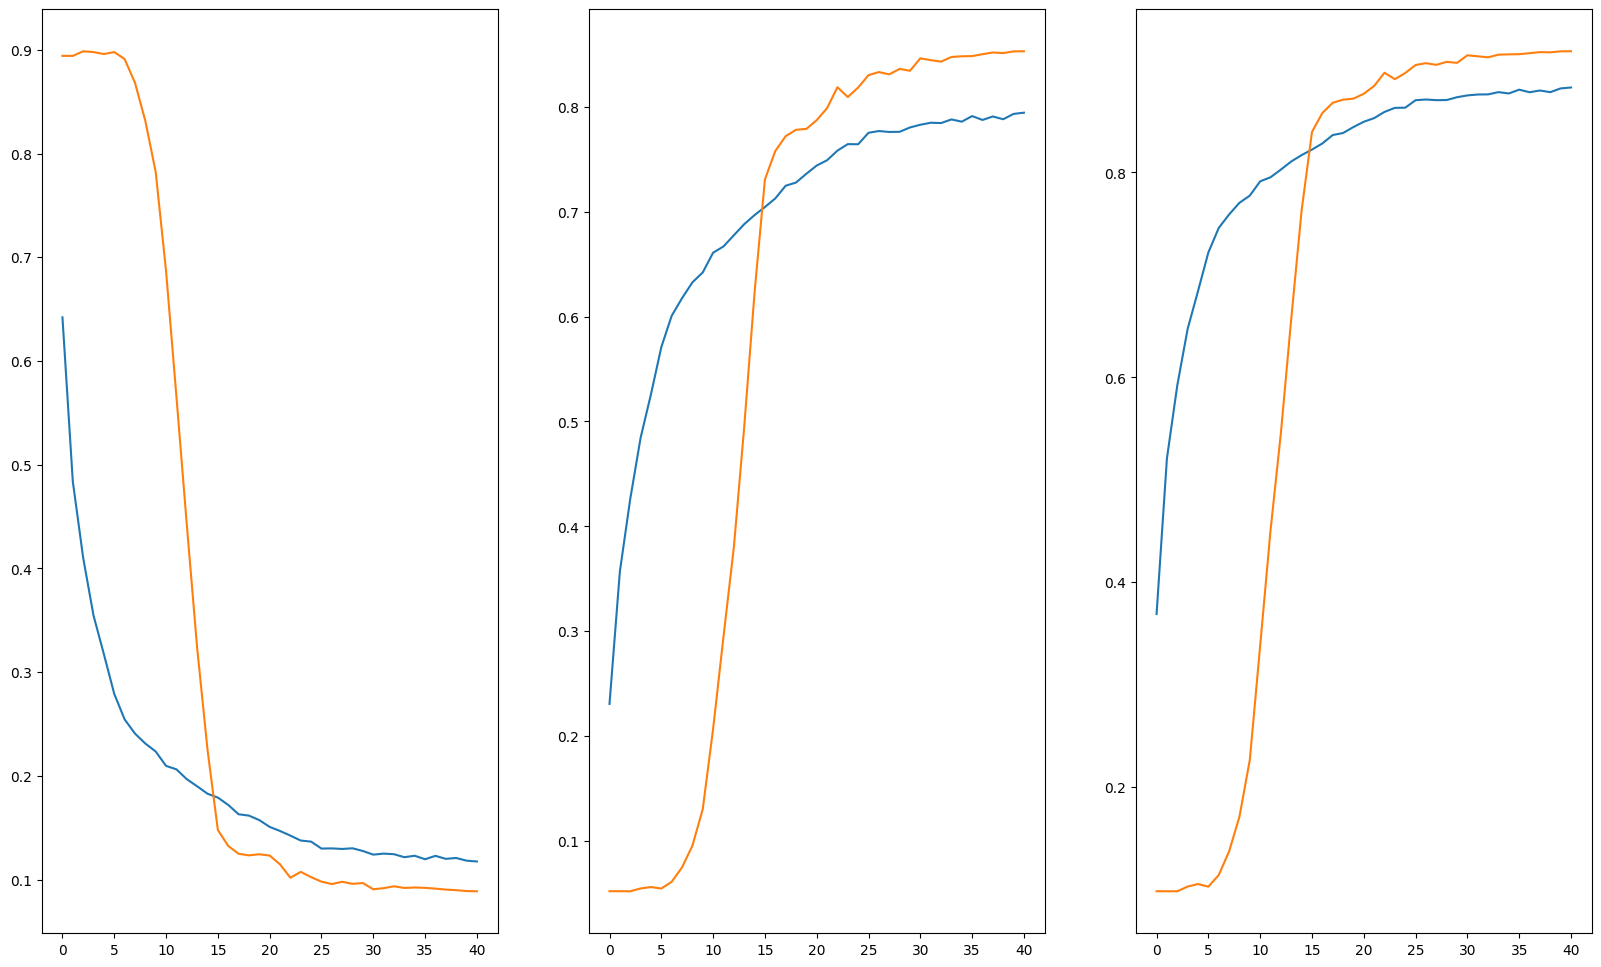

In [ ]:
# 4. Model
print("Start Training")
batch_size = 256
lr = 0.005
epochs = 2000

model = UNet1D()
model.summary()

# 5. Train
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=f1_loss(),   # Dice loss
              metrics=[Jaccard, f1_score])

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(    # 특정 성능지표가 좋을 때, loss가 낮을 때를 저장해줄 수 있음.  이 경우 f1-score가 최대일 때 가중치만 저장하겠다. 이때 파일 명은 'weights.h5'임.
        filepath="weights.h5",
        # monitor='val_loss',
        # mode='min',
        monitor="val_f1_score",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
        verbose=1),

    tf.keras.callbacks.EarlyStopping(  # 모델이 최적화가 되었는데 계속 학습이 되면 과적합 될 수 있으므로 EarlyStopping을 걸어준다.
        monitor="val_f1_score",
        min_delta=0.005,
        mode="max",
        patience=10,
        verbose=1),

    tf.keras.callbacks.ReduceLROnPlateau(   # Reduce Learning Rate : 성능이 개선되지 않을 때 lr을 줄이는 함수.
        monitor='val_f1_score',   # patience(=5번) 동안 f1-score가 0.01만큼 개선되지 않을 때 lr에 factor(=0.5)를 곱해서 lr을 줄인다. 
        # lr ~ 0 이면 더이상 학습이 일어나지 않으므로 줄일 수 있는 최소한의 lr = 'min_lr'에 도달하게 되면 성능이 개선되지 않더라더 lr을 더이상 줄이지 않는다.
        factor=0.5,
        patience=5, 
        mode='max',
        min_delta=0.01,   
        cooldown=0,
        min_lr=0.0001,
        verbose=1)
]

history = model.fit(train[0], train[1],
                    validation_data=(valid[0], valid[1]),
                    callbacks=callbacks_list,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    )


loss = history.history['loss']
val_loss = history.history['val_loss']
Jaccard = history.history["Jaccard"]
val_Jaccard = history.history["val_Jaccard"]
f1 = history.history["f1_score"]
val_f1 = history.history["val_f1_score"]

epochs_range = range(len(loss))
fig, ax = plt.subplots(1, 3, figsize = (20, 12))
ax[0].plot(epochs_range, loss, label='Training Loss')
ax[0].plot(epochs_range, val_loss, label='Validation Loss')

ax[1].plot(epochs_range, Jaccard, label='Training Jaccard')
ax[1].plot(epochs_range, val_Jaccard, label='Validation Jaccard')

ax[2].plot(epochs_range, f1, label='Training f1-score')
ax[2].plot(epochs_range, val_f1, label='Validation f1-score')
plt.show()

del model, history, train


### Inference

(270, 2000, 12)
1/1 [==============================] - 1s 1s/step


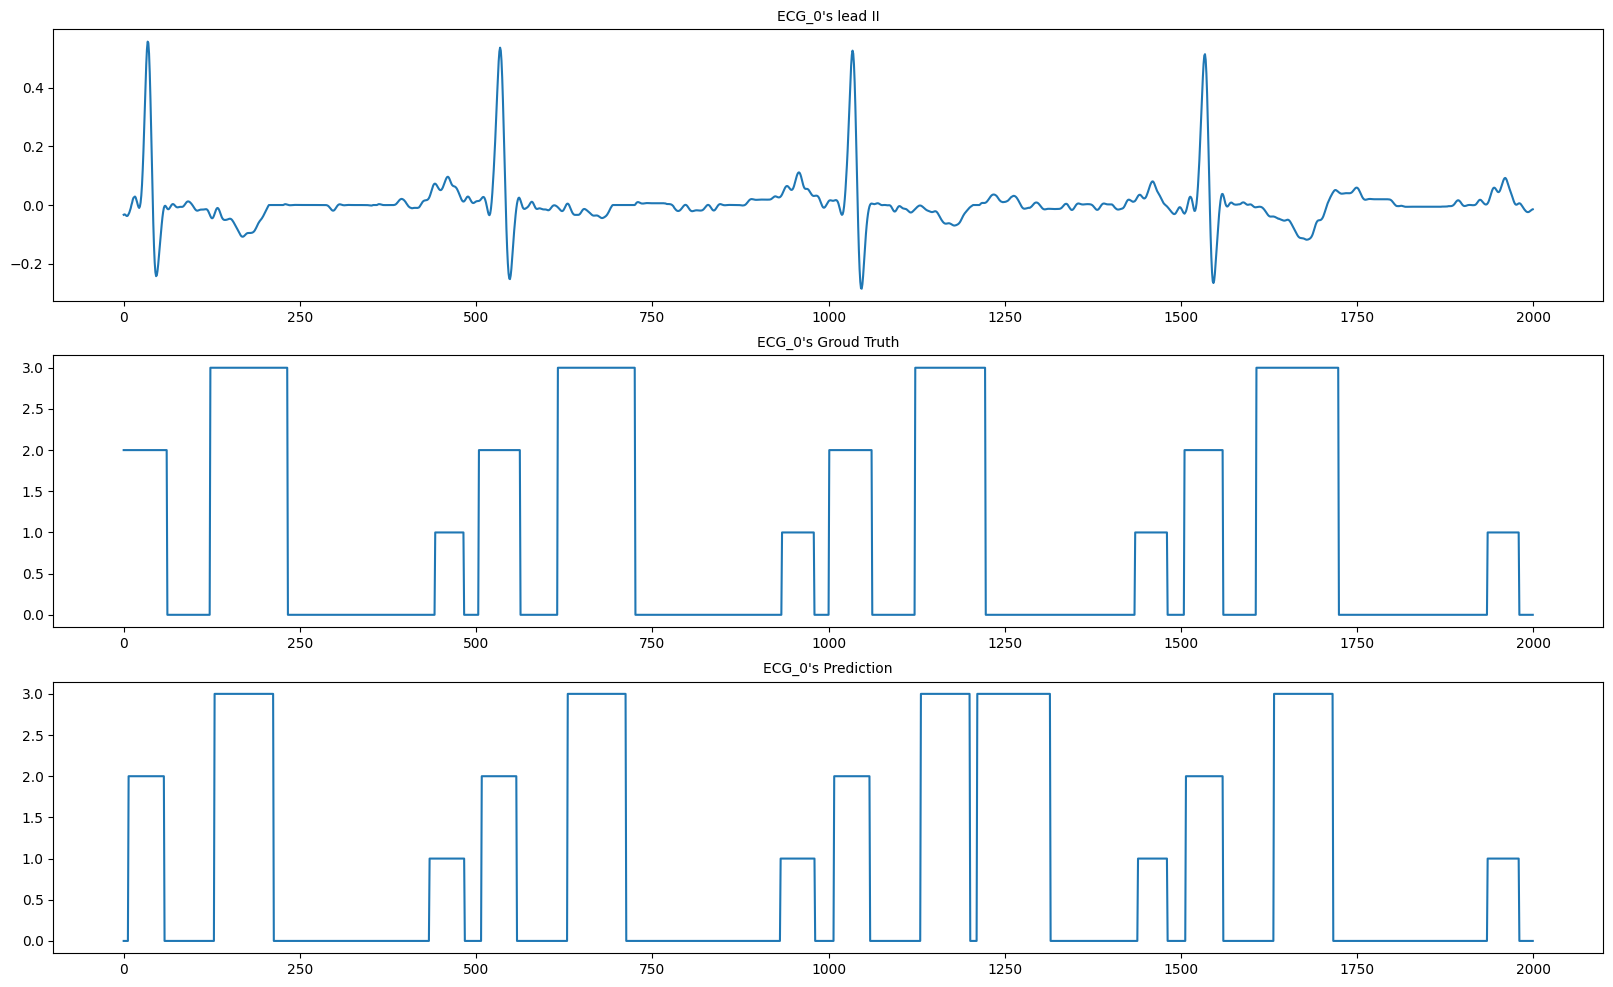

1/1 [==============================] - 0s 24ms/step


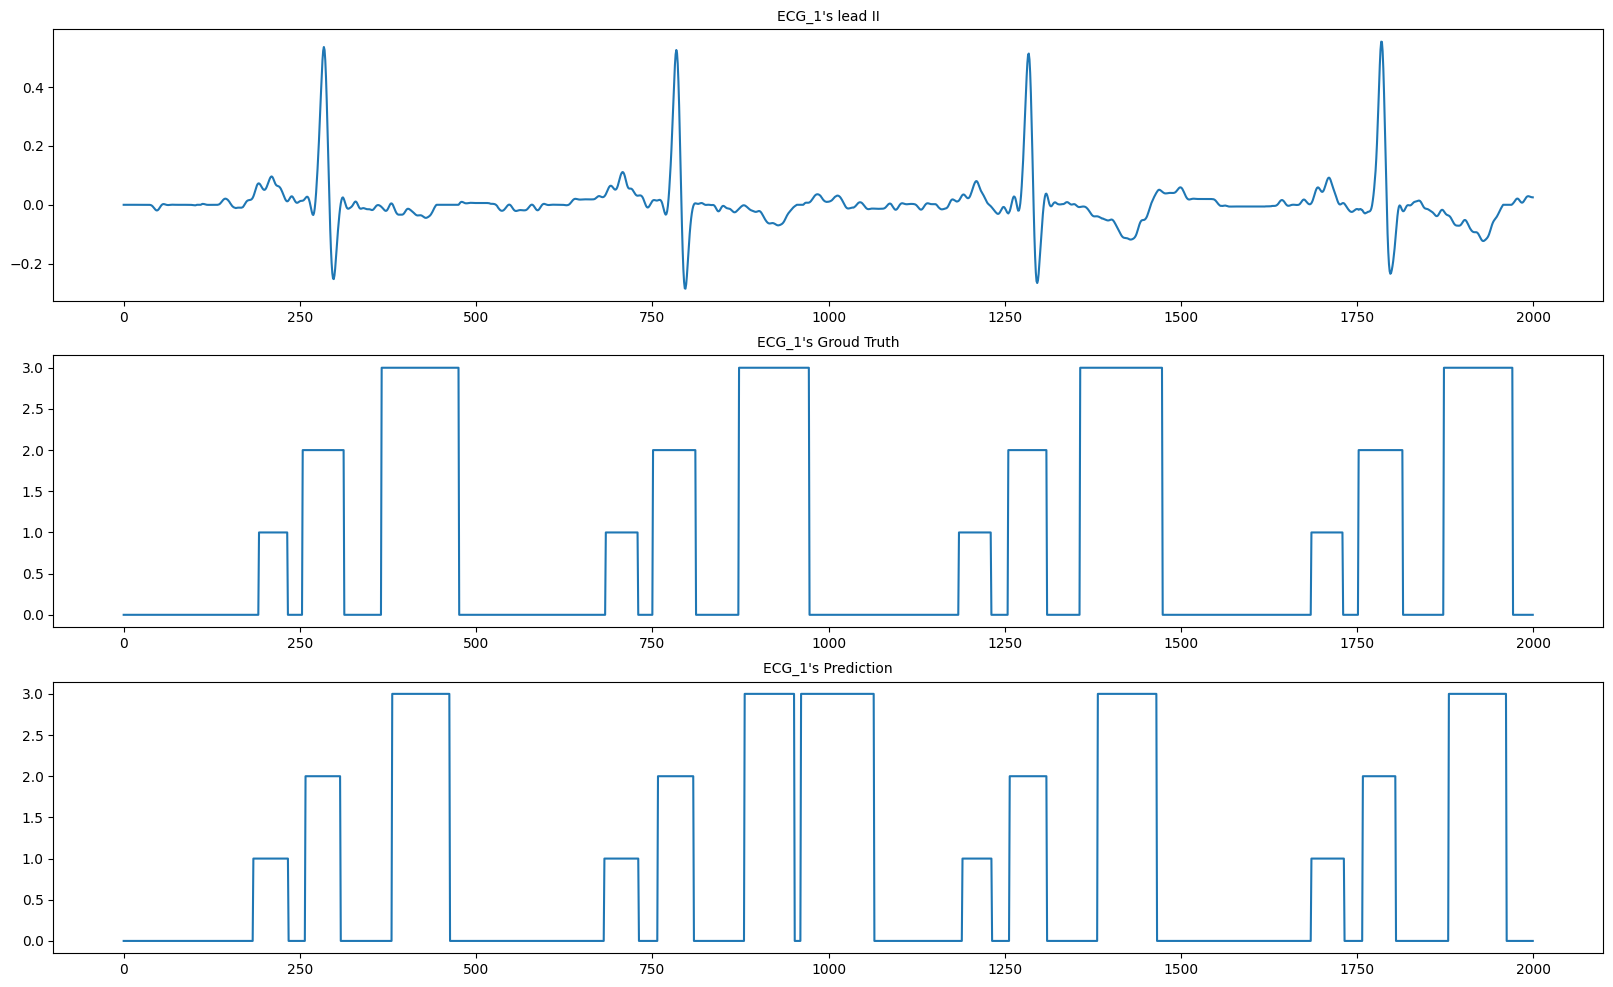

1/1 [==============================] - 0s 23ms/step


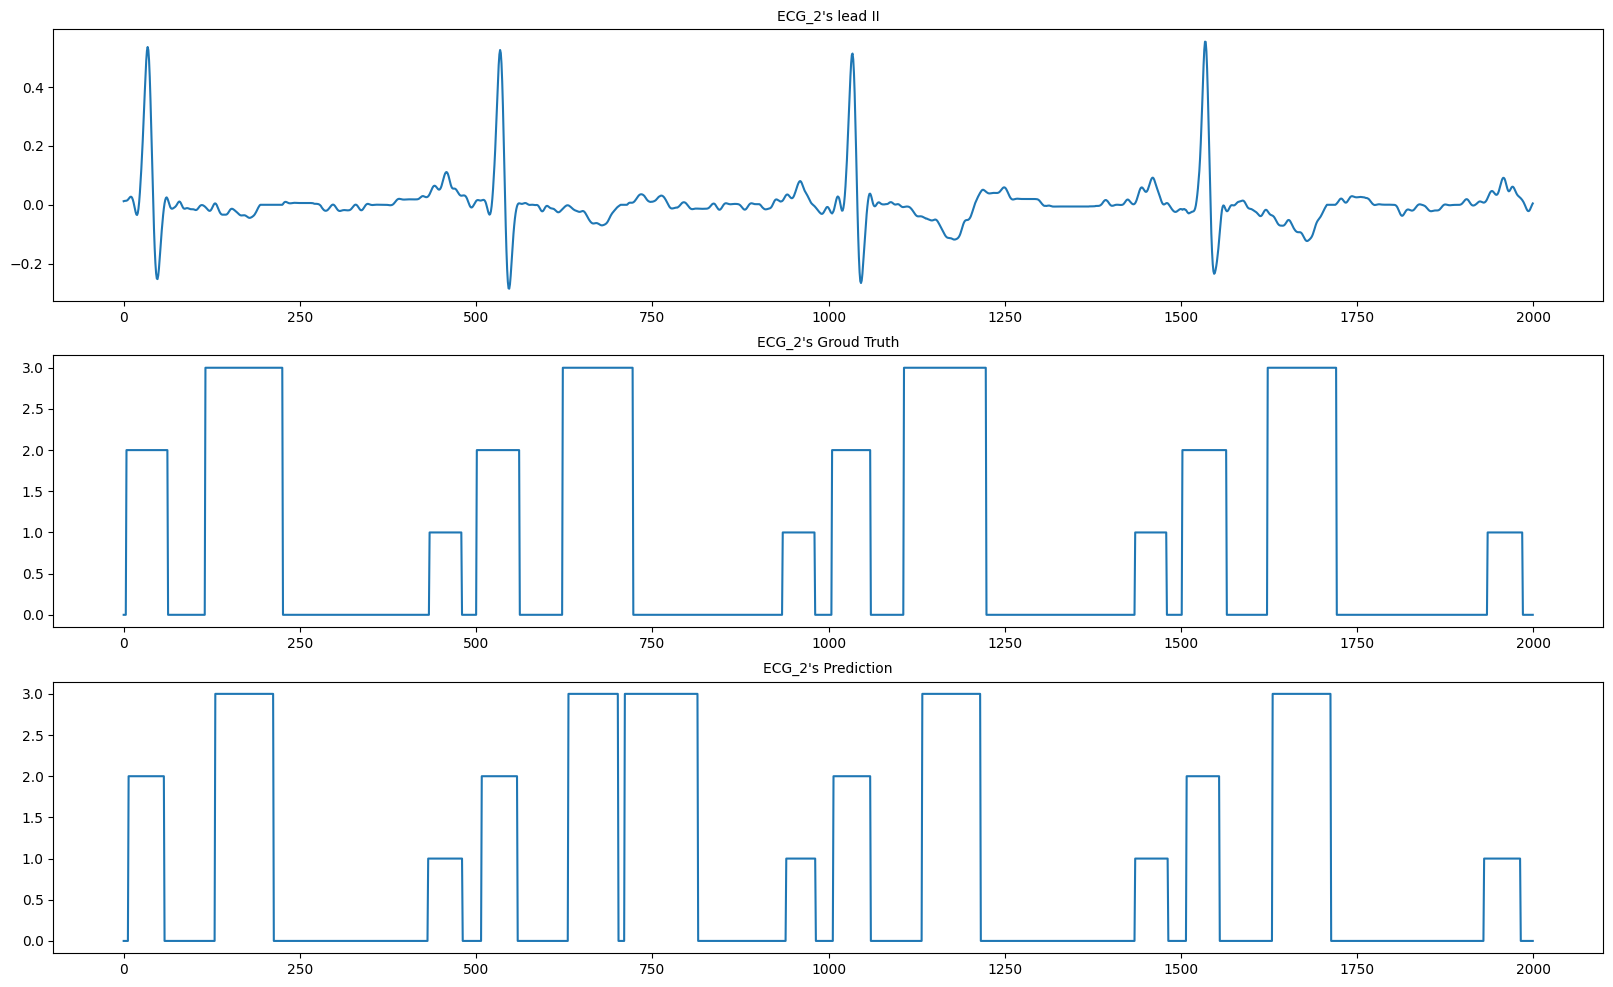

1/1 [==============================] - 0s 21ms/step


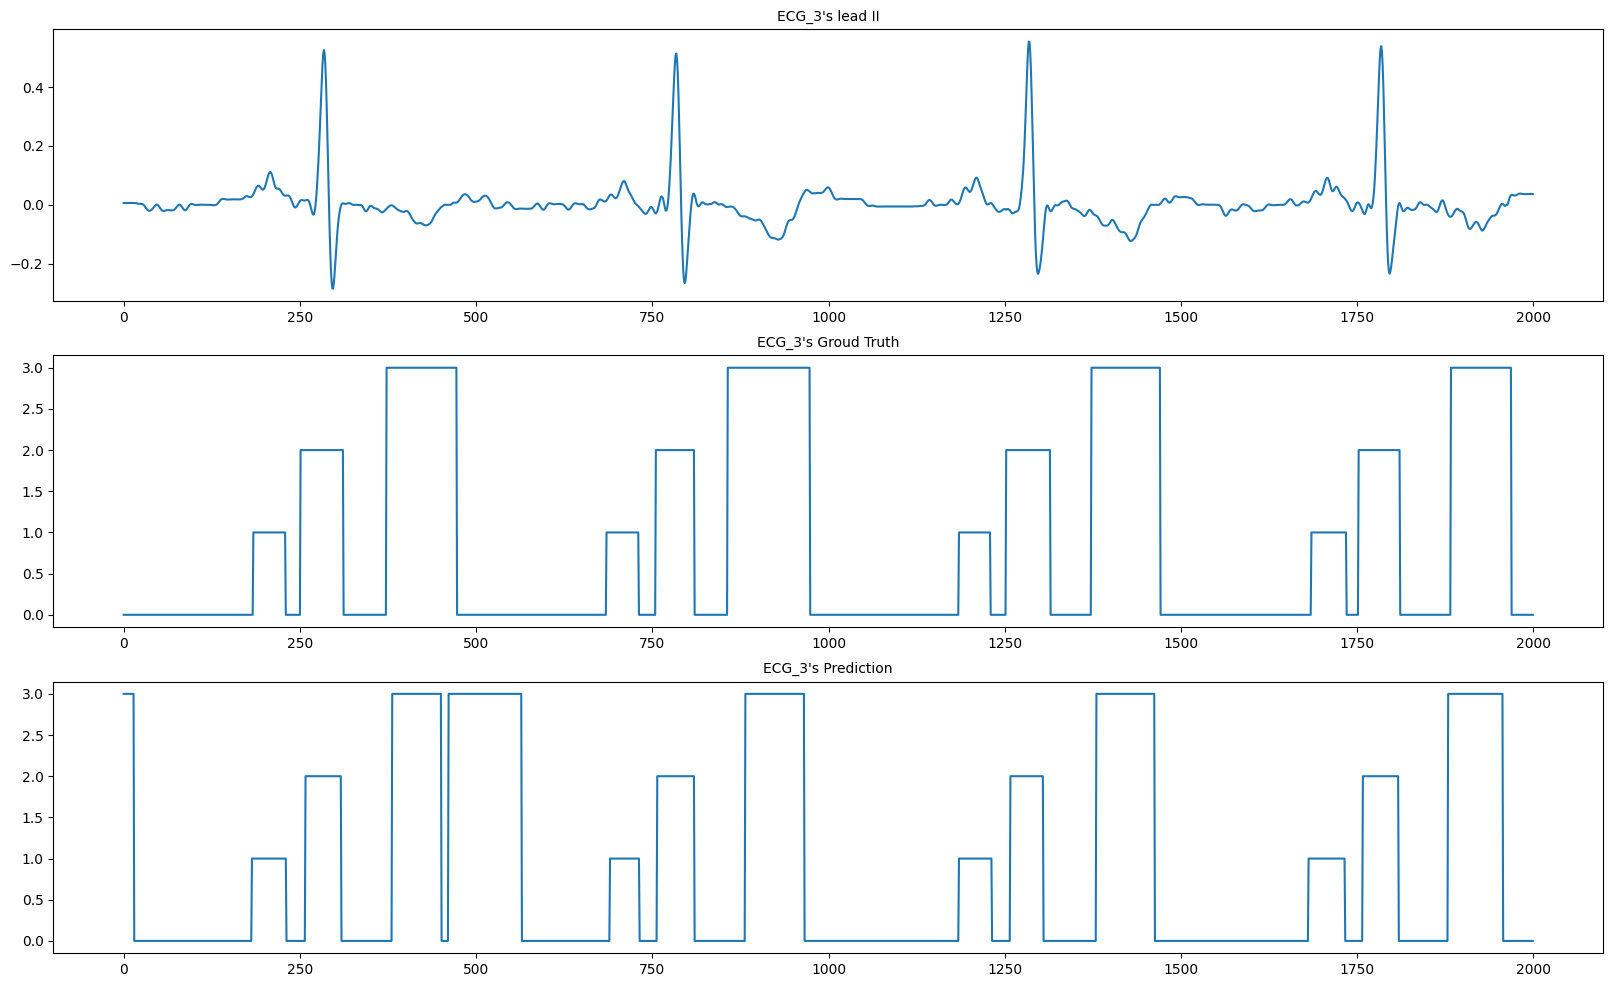

1/1 [==============================] - 0s 26ms/step


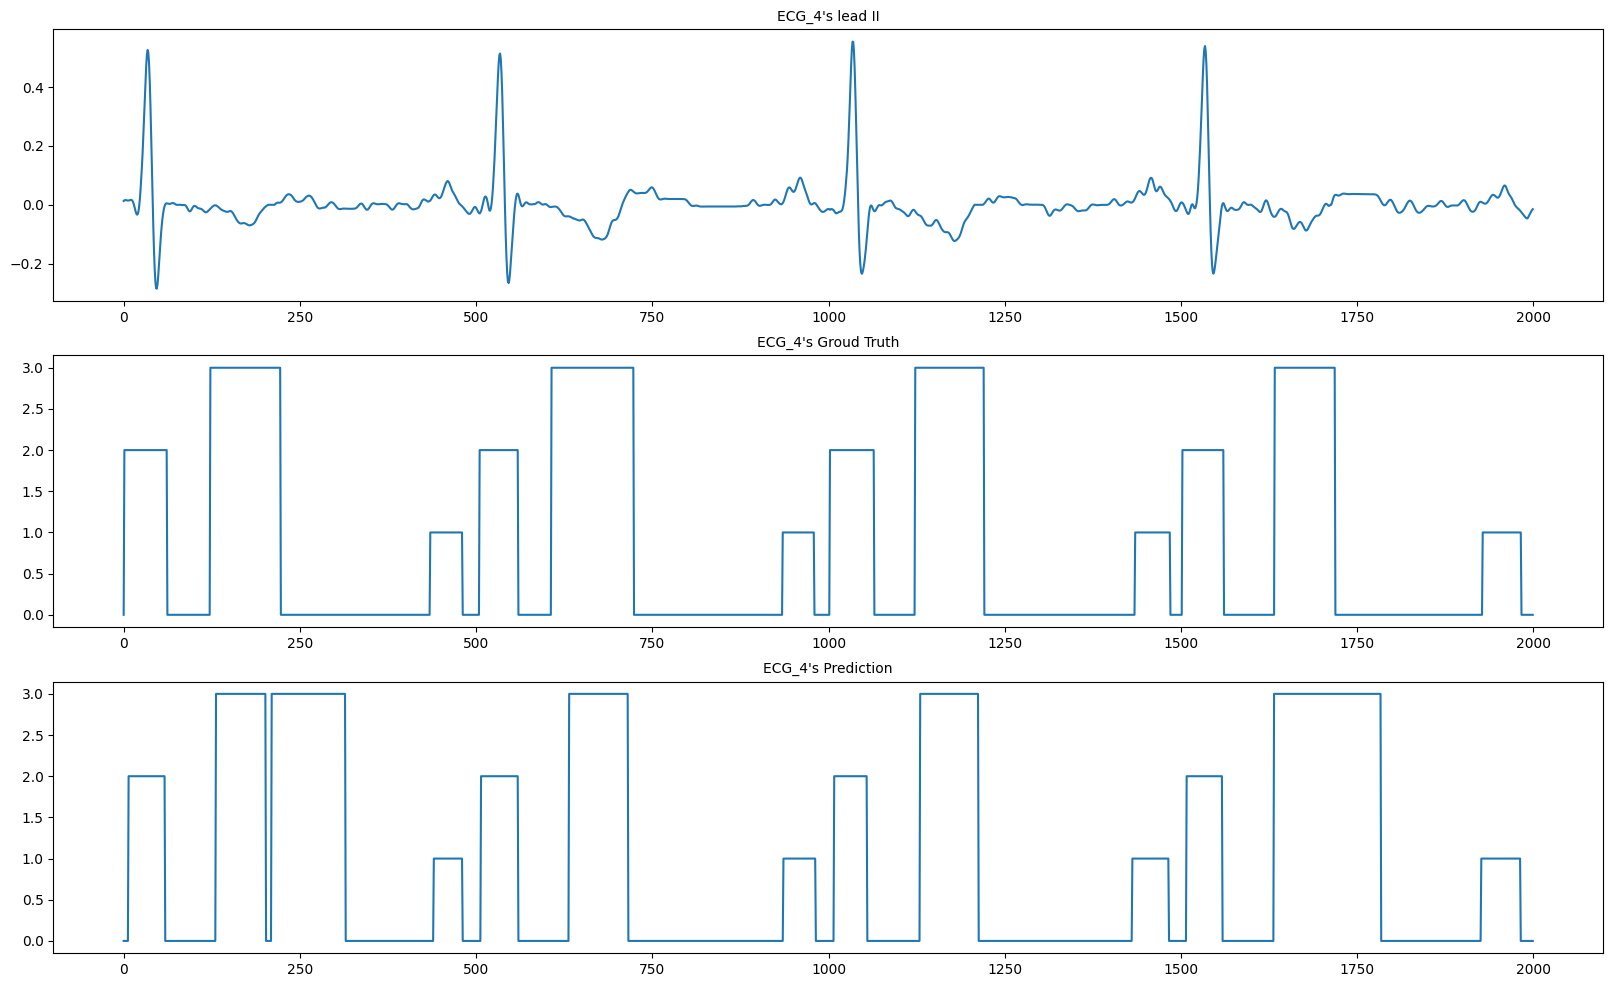

1/1 [==============================] - 0s 30ms/step


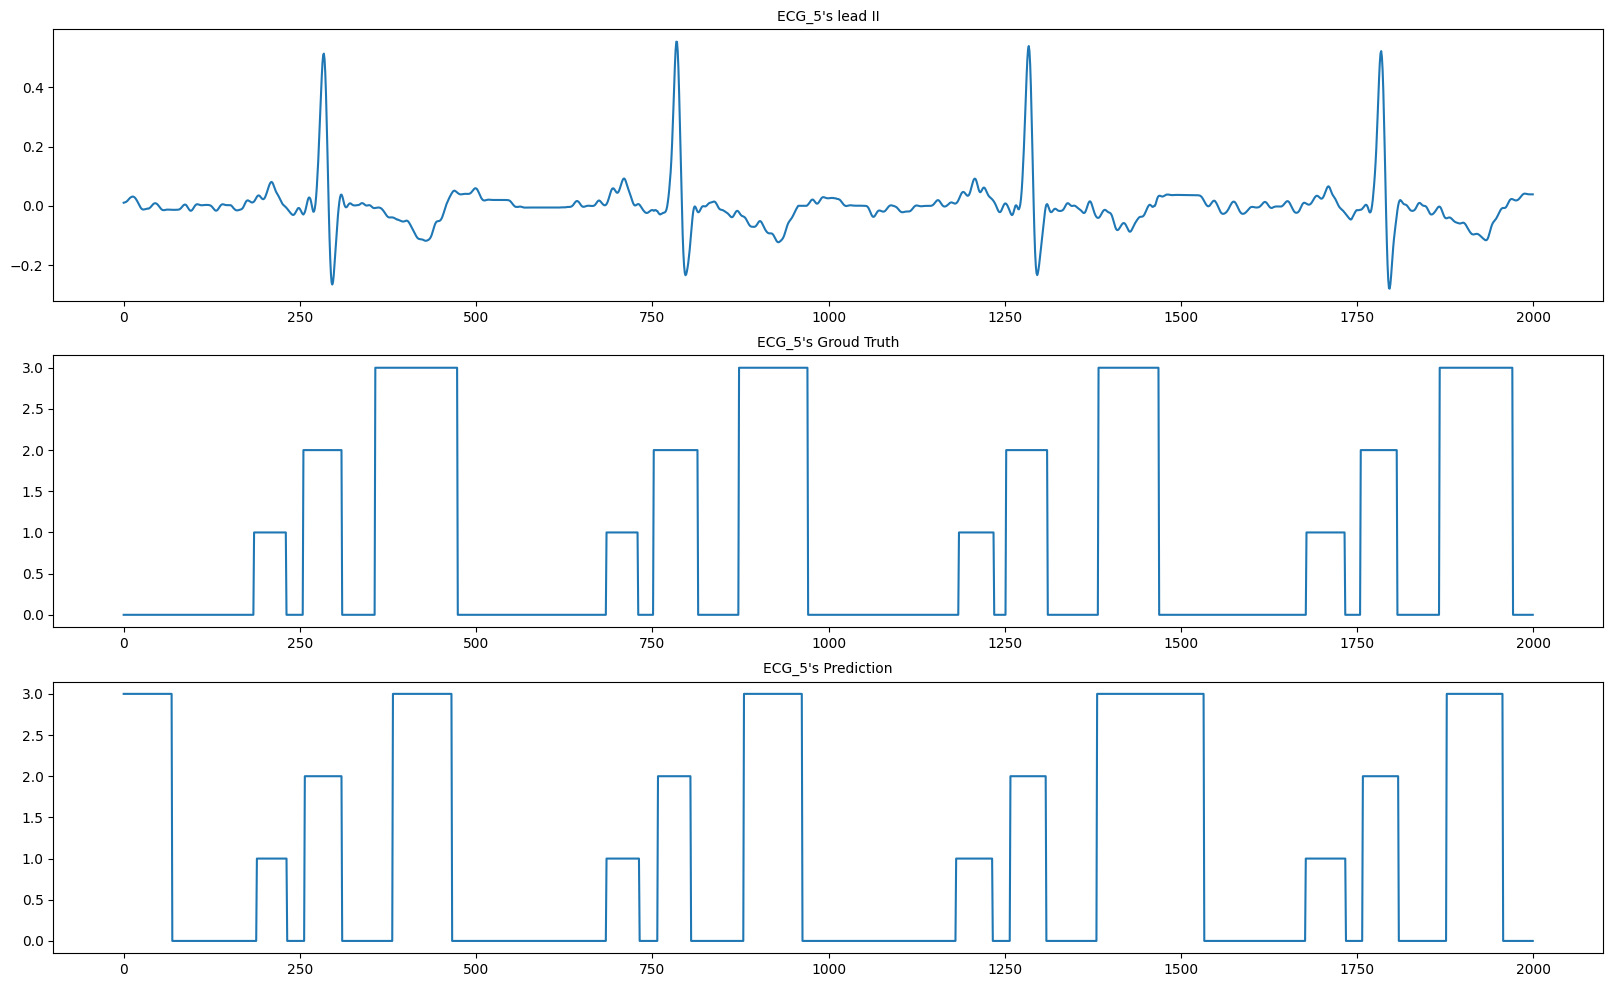

1/1 [==============================] - 0s 32ms/step


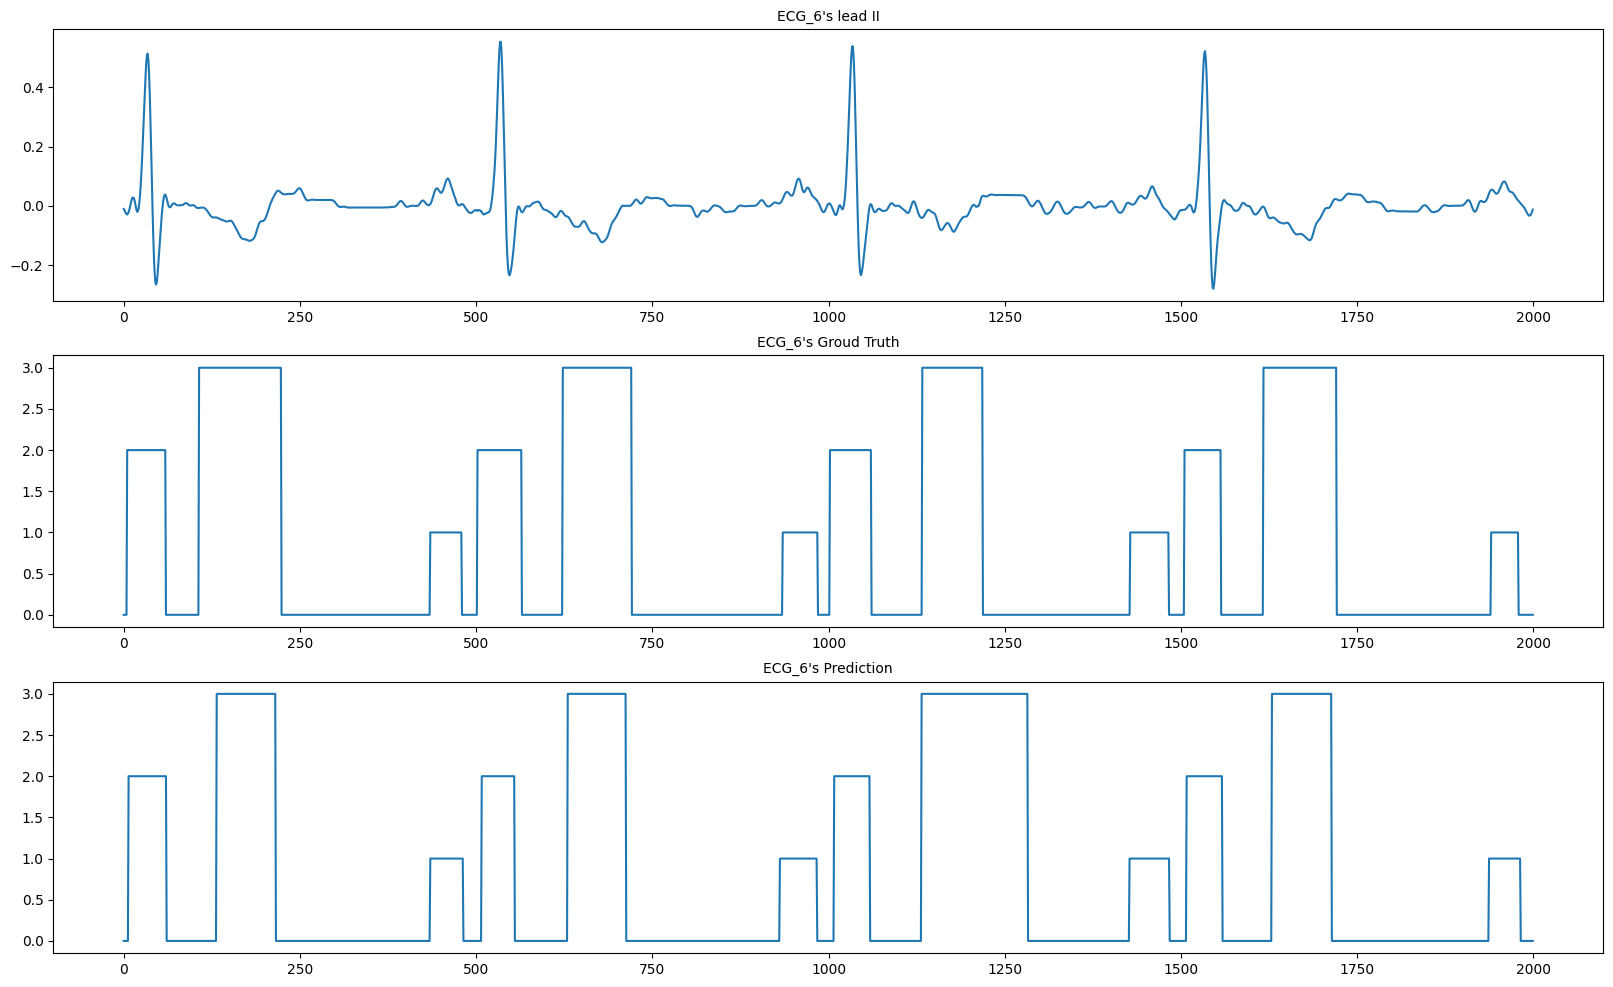

1/1 [==============================] - 0s 32ms/step


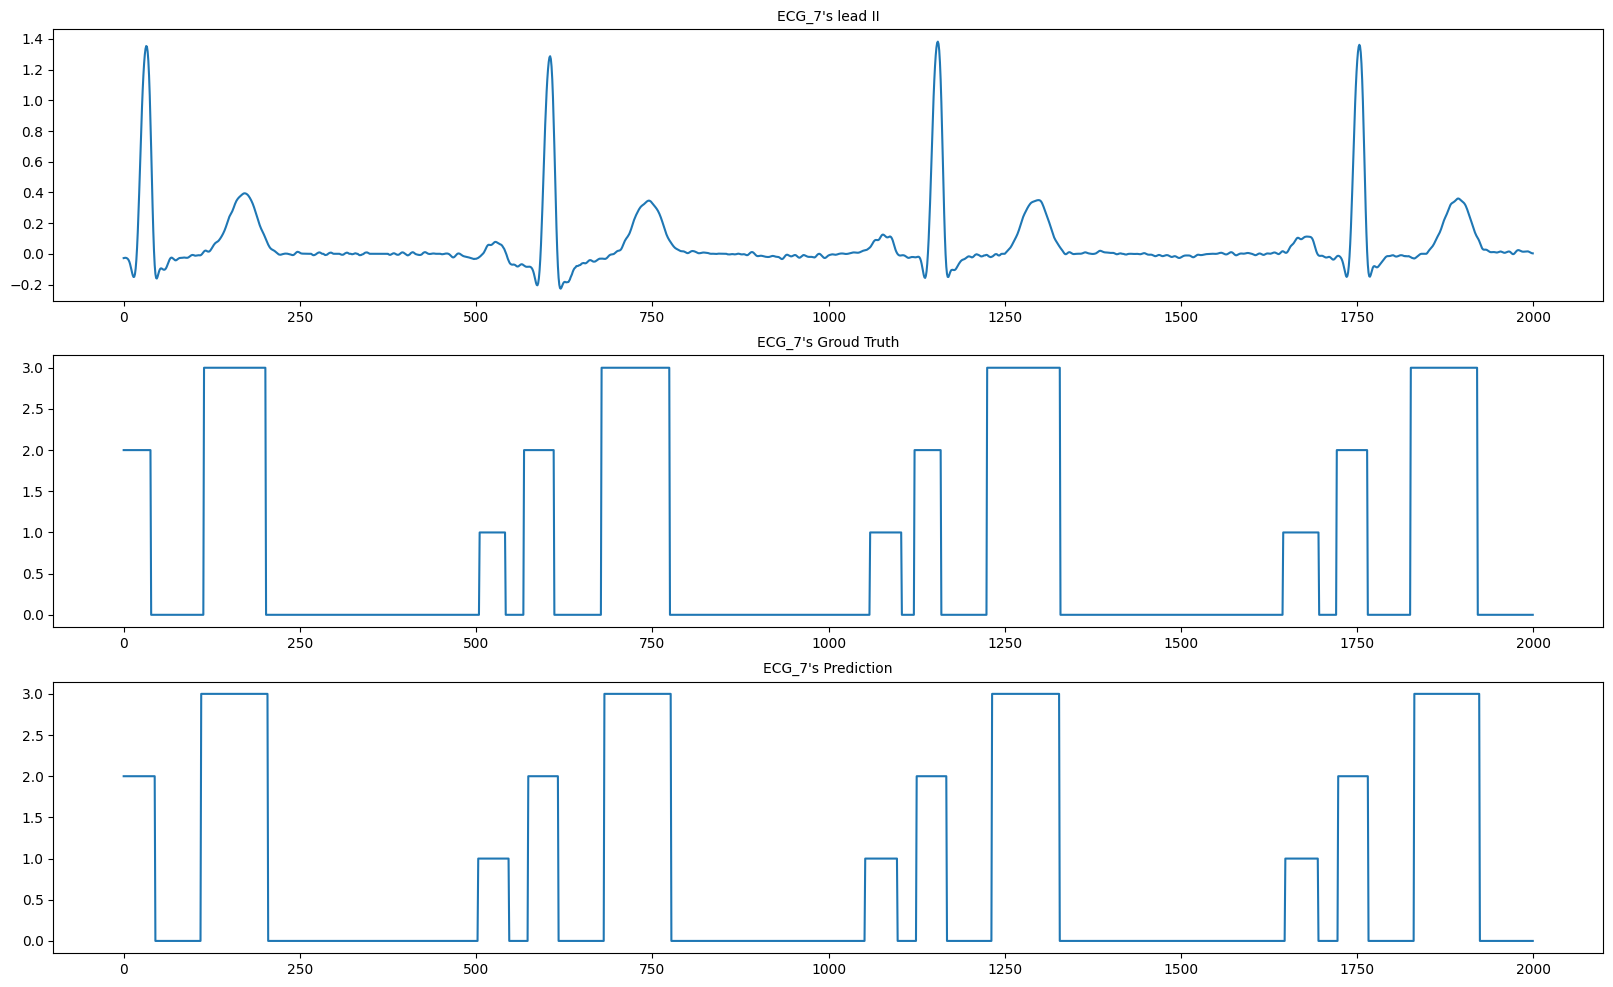

1/1 [==============================] - 0s 32ms/step


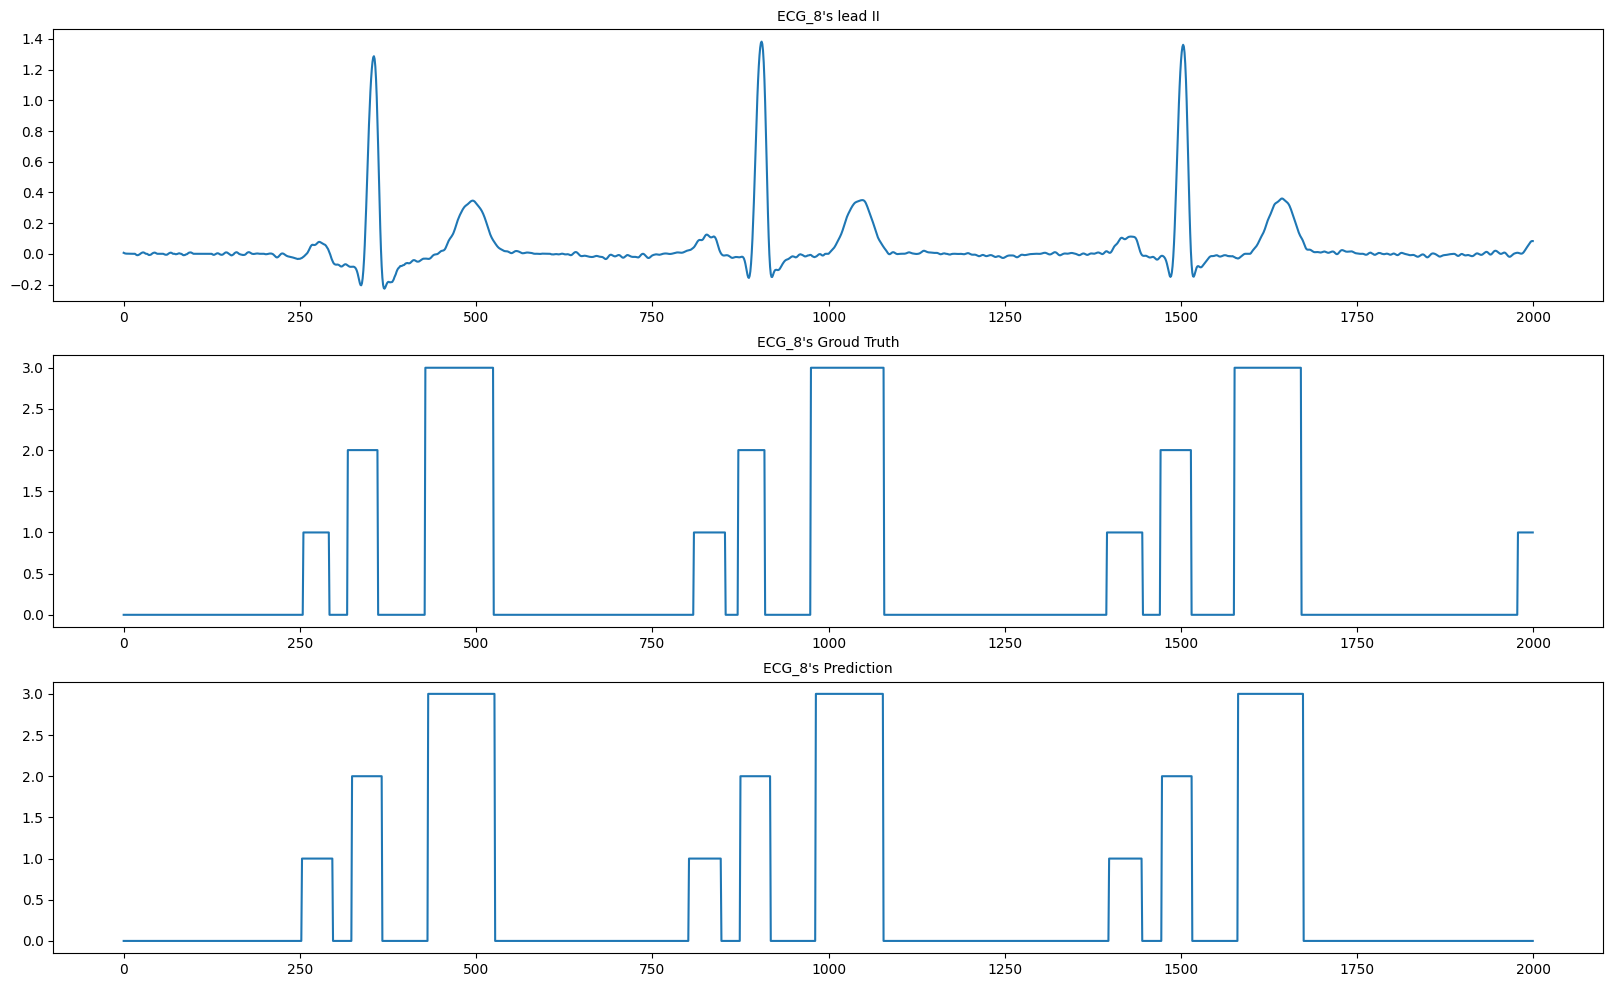

1/1 [==============================] - 0s 27ms/step


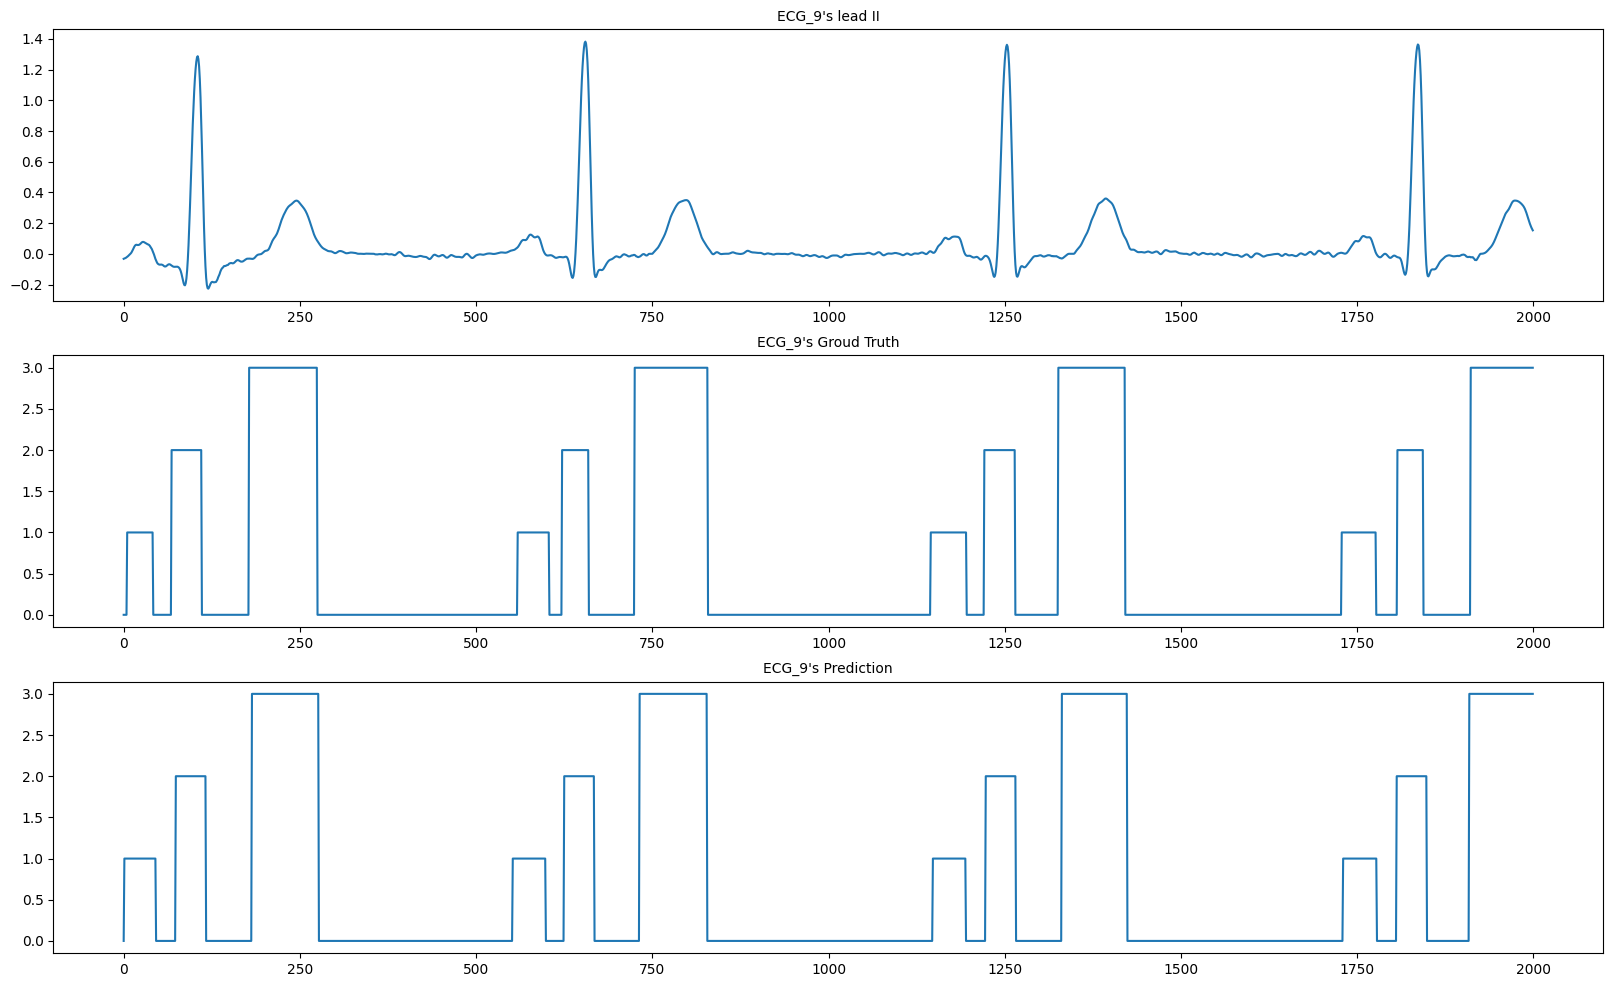

1/1 [==============================] - 0s 22ms/step


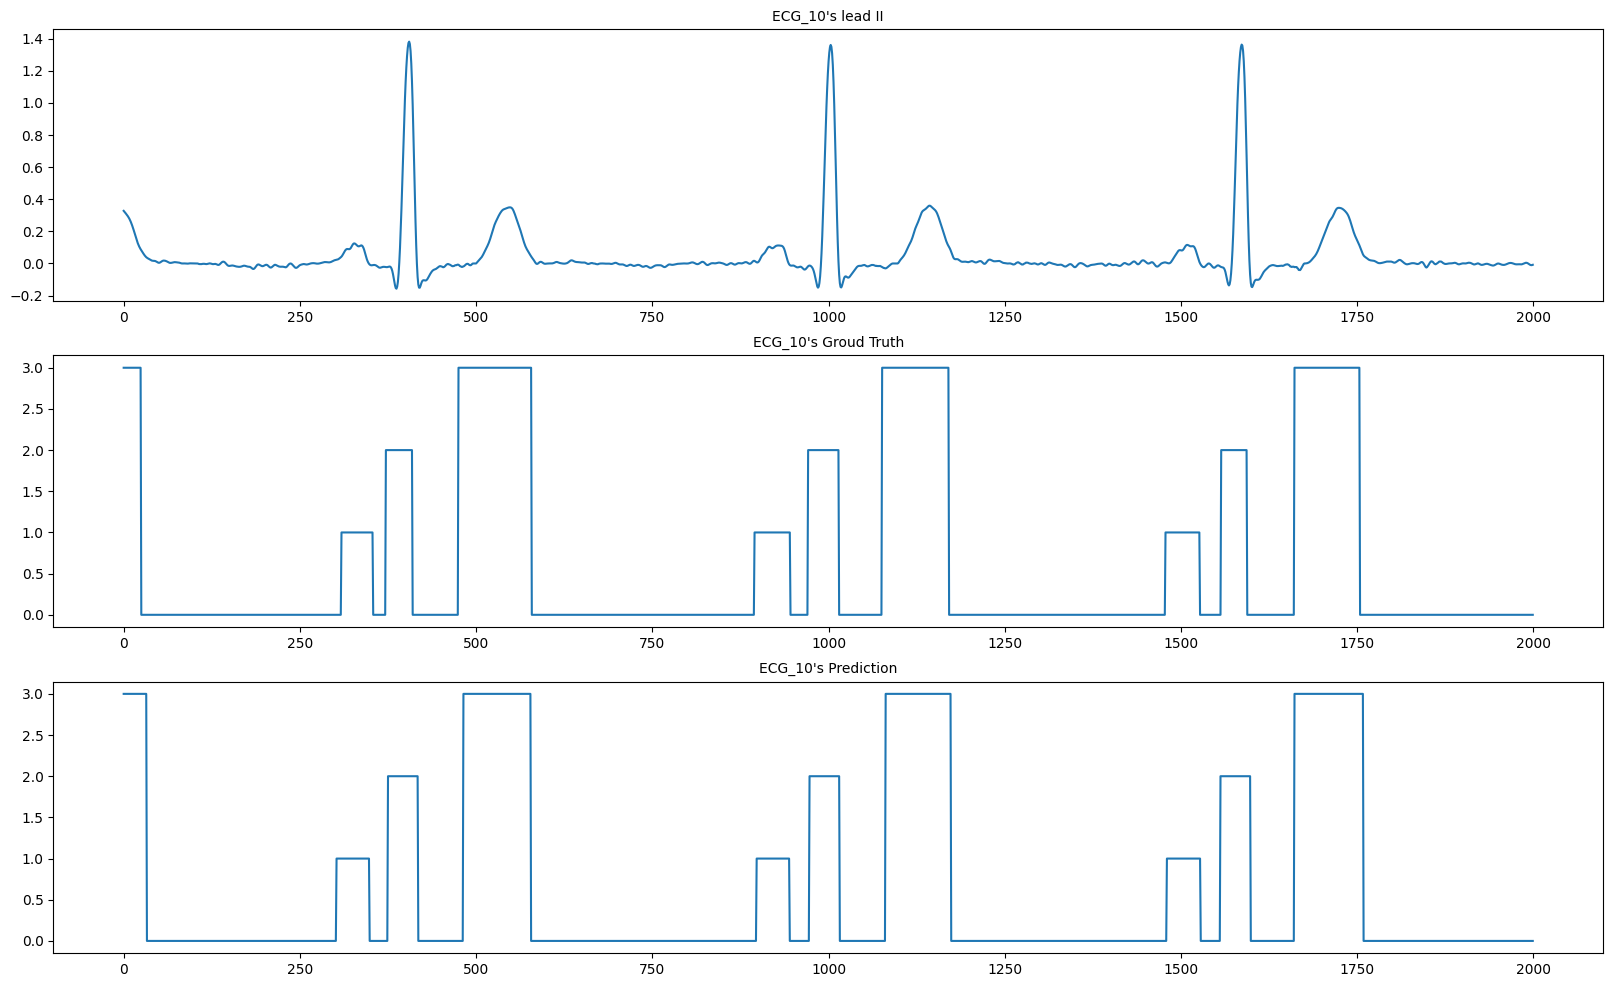

1/1 [==============================] - 0s 22ms/step


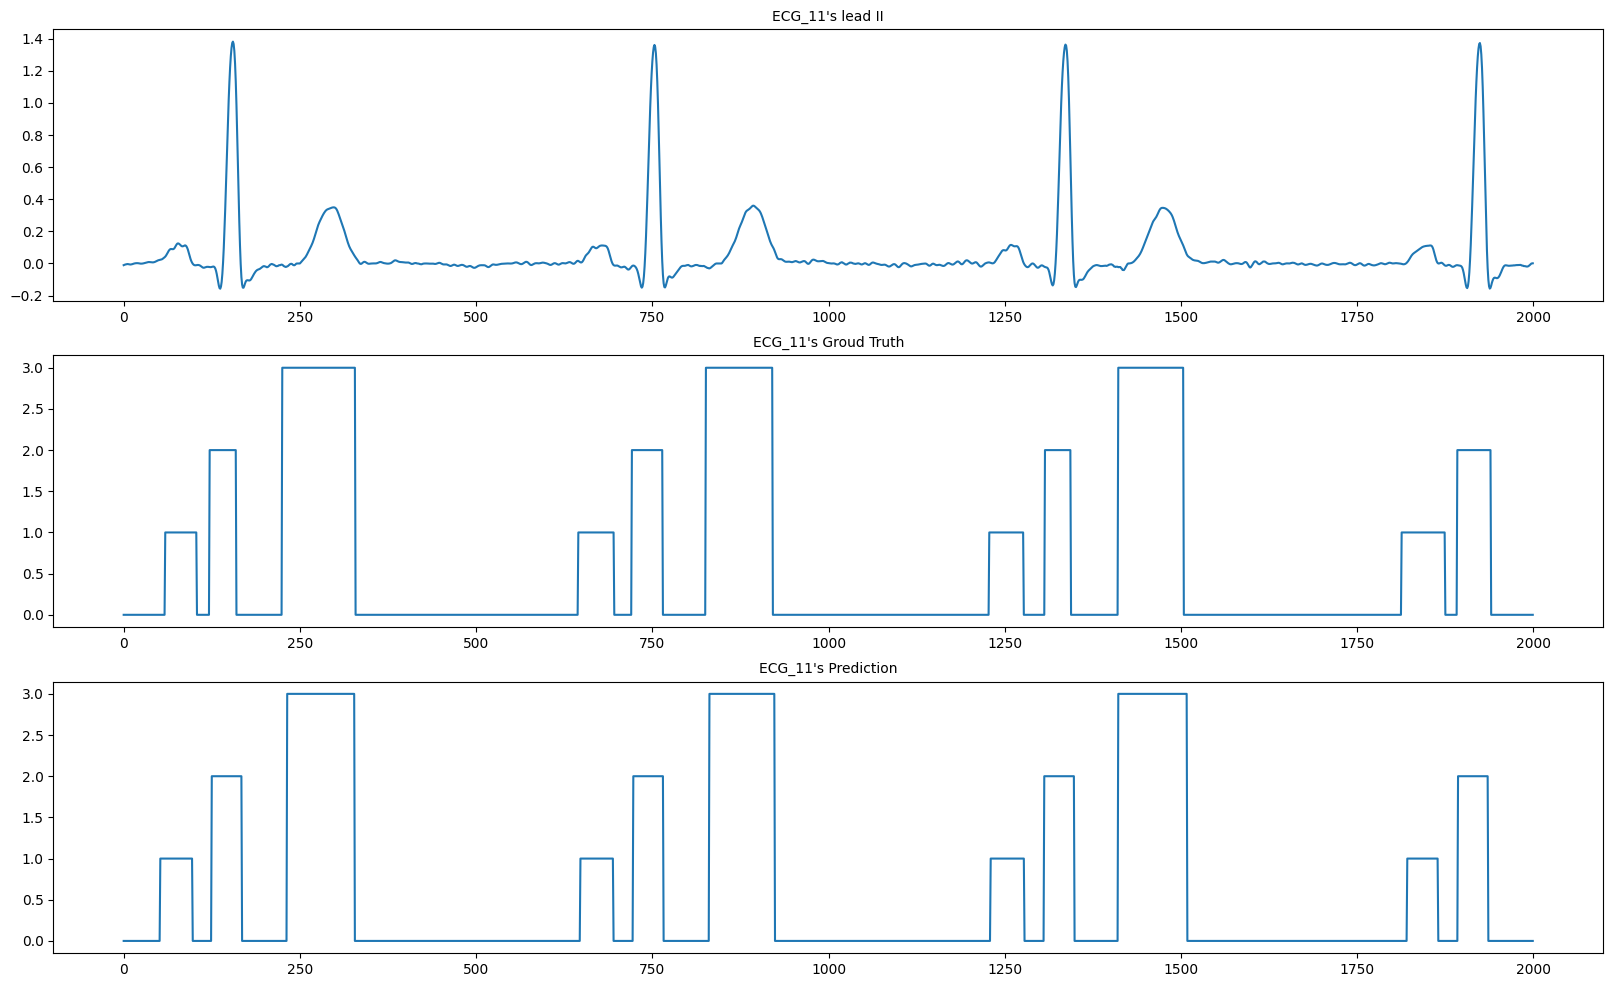

1/1 [==============================] - 0s 23ms/step


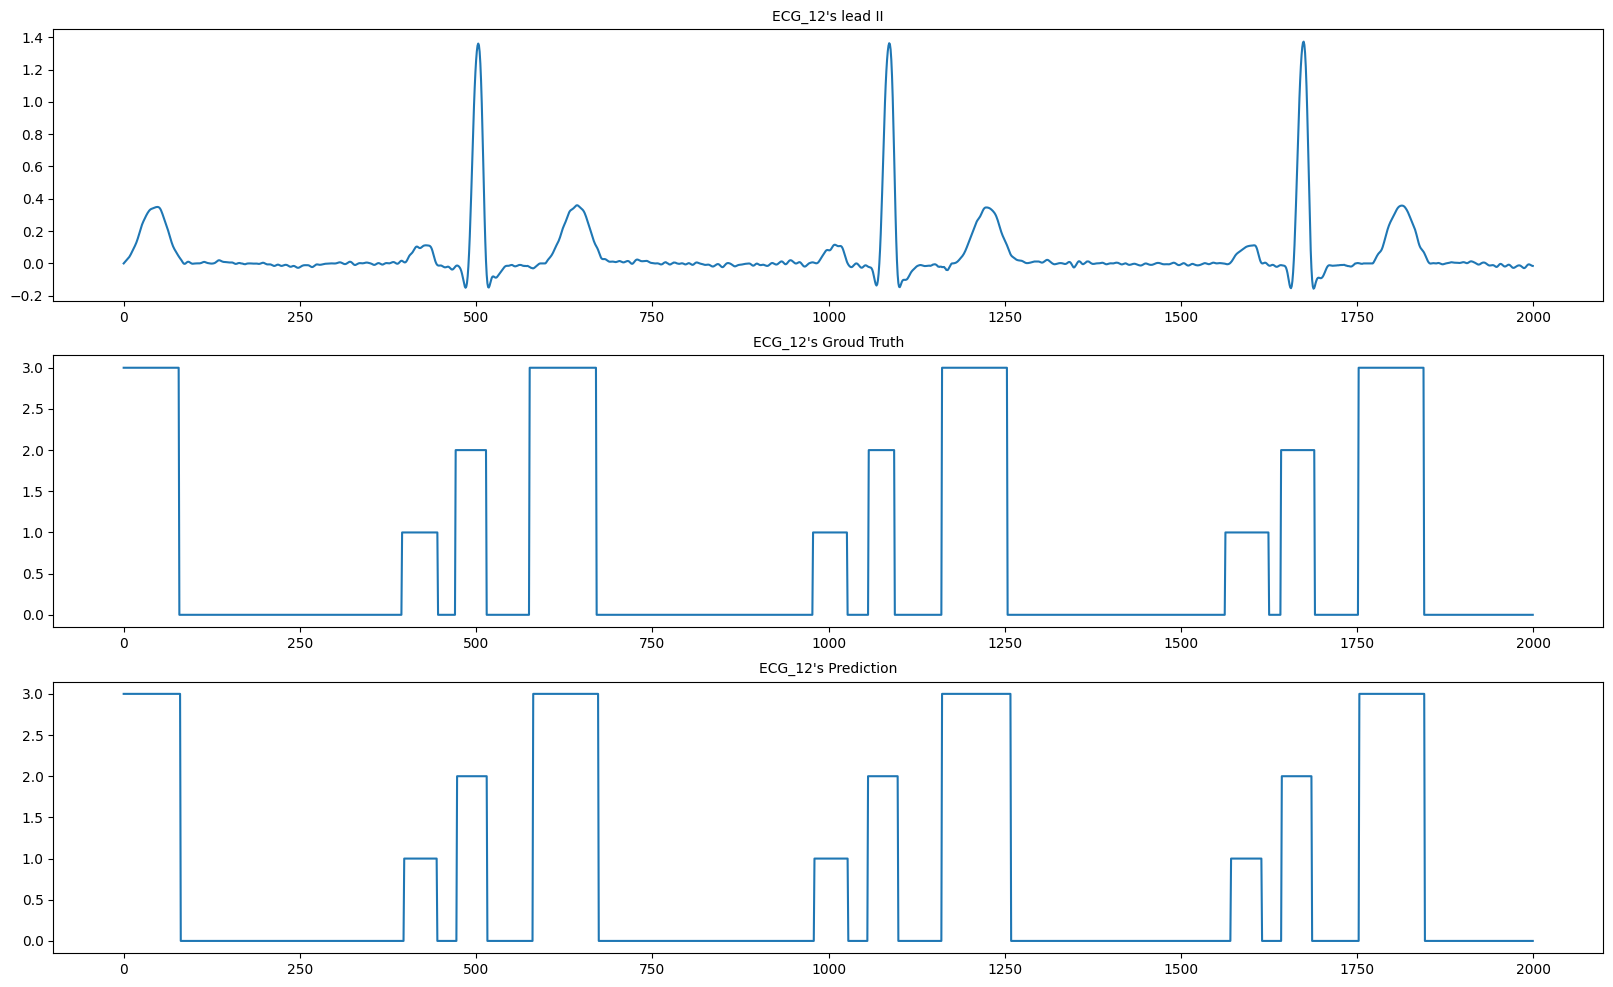

1/1 [==============================] - 0s 23ms/step


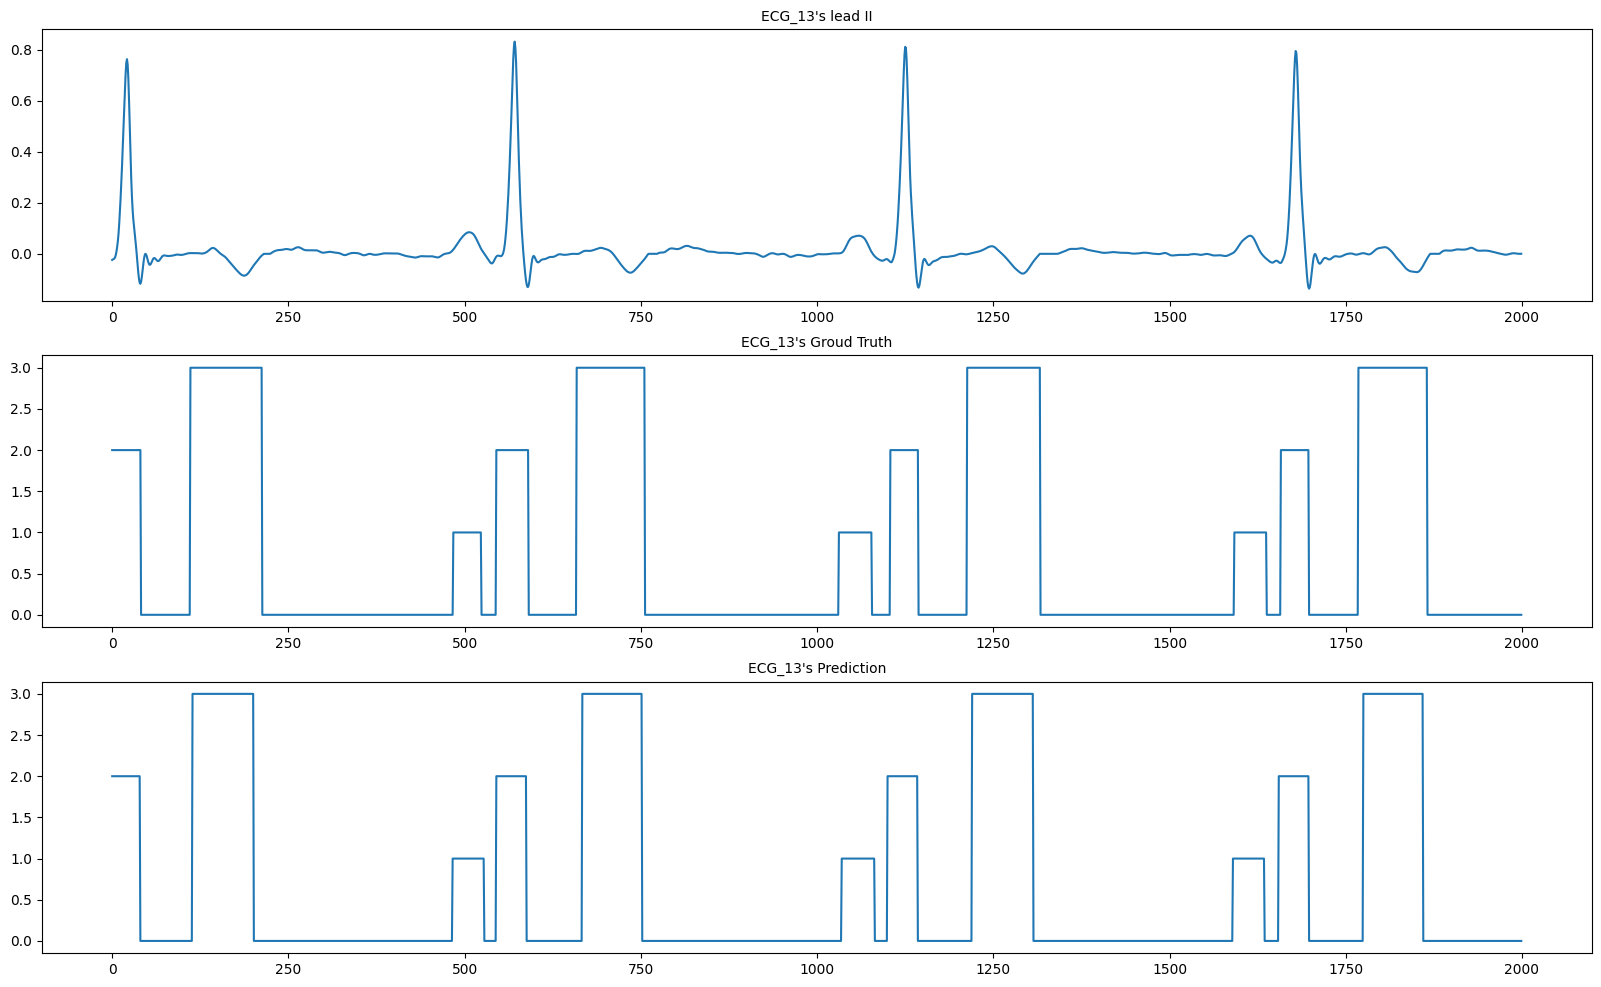

1/1 [==============================] - 0s 26ms/step


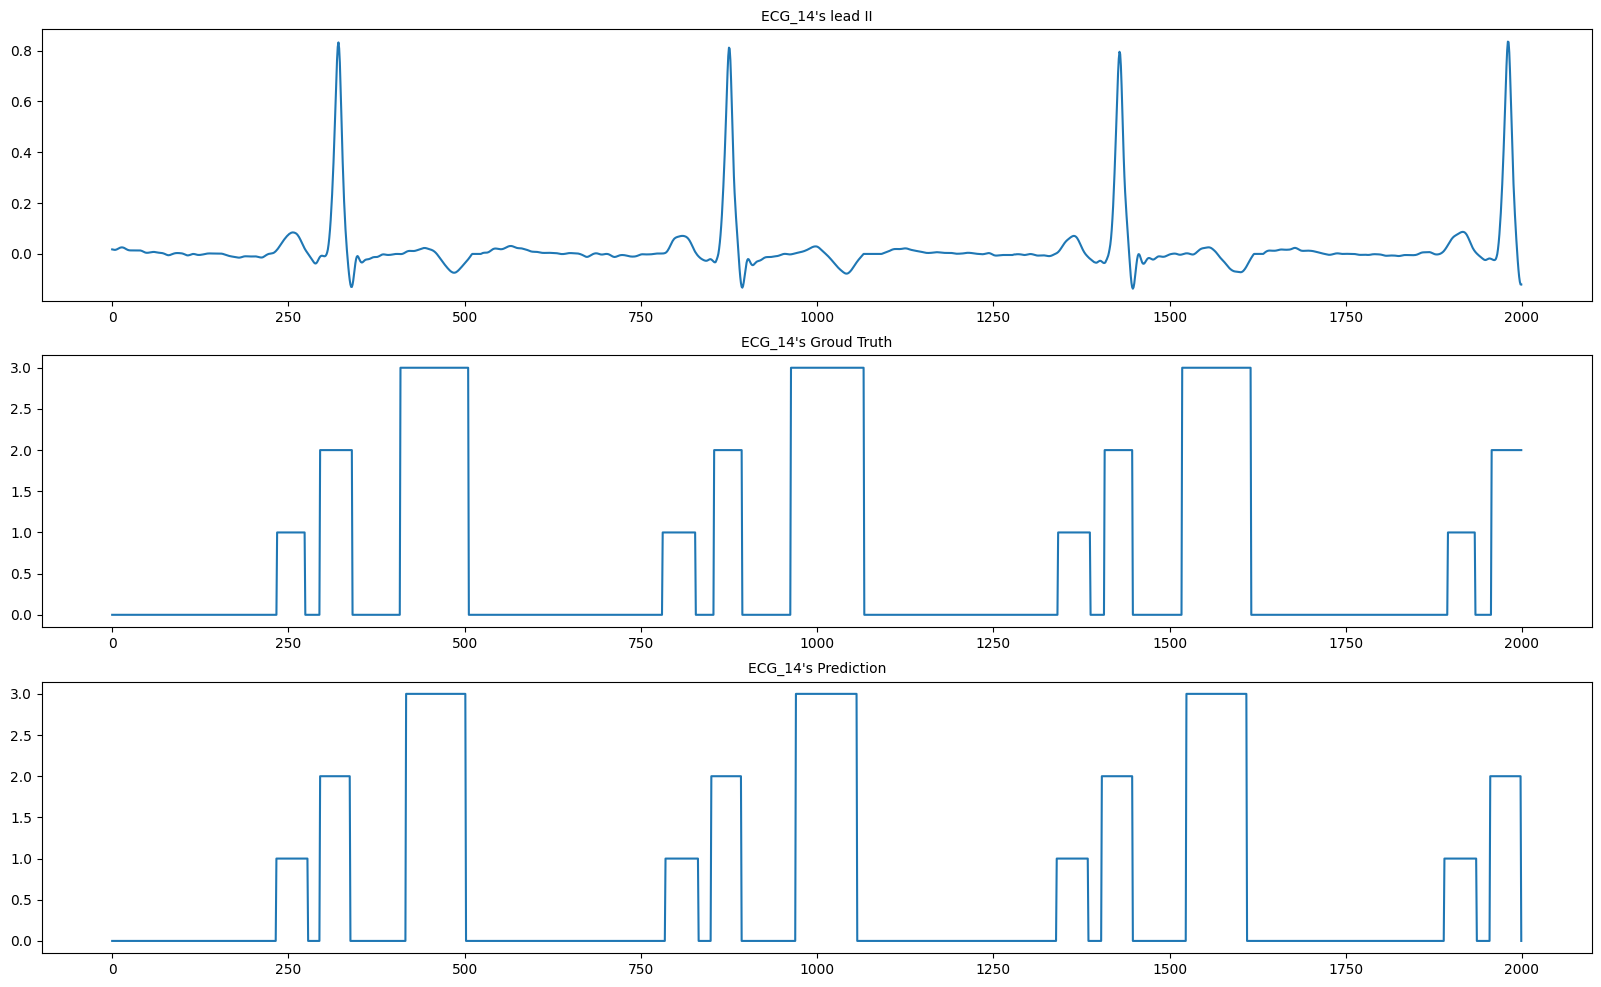

1/1 [==============================] - 0s 26ms/step


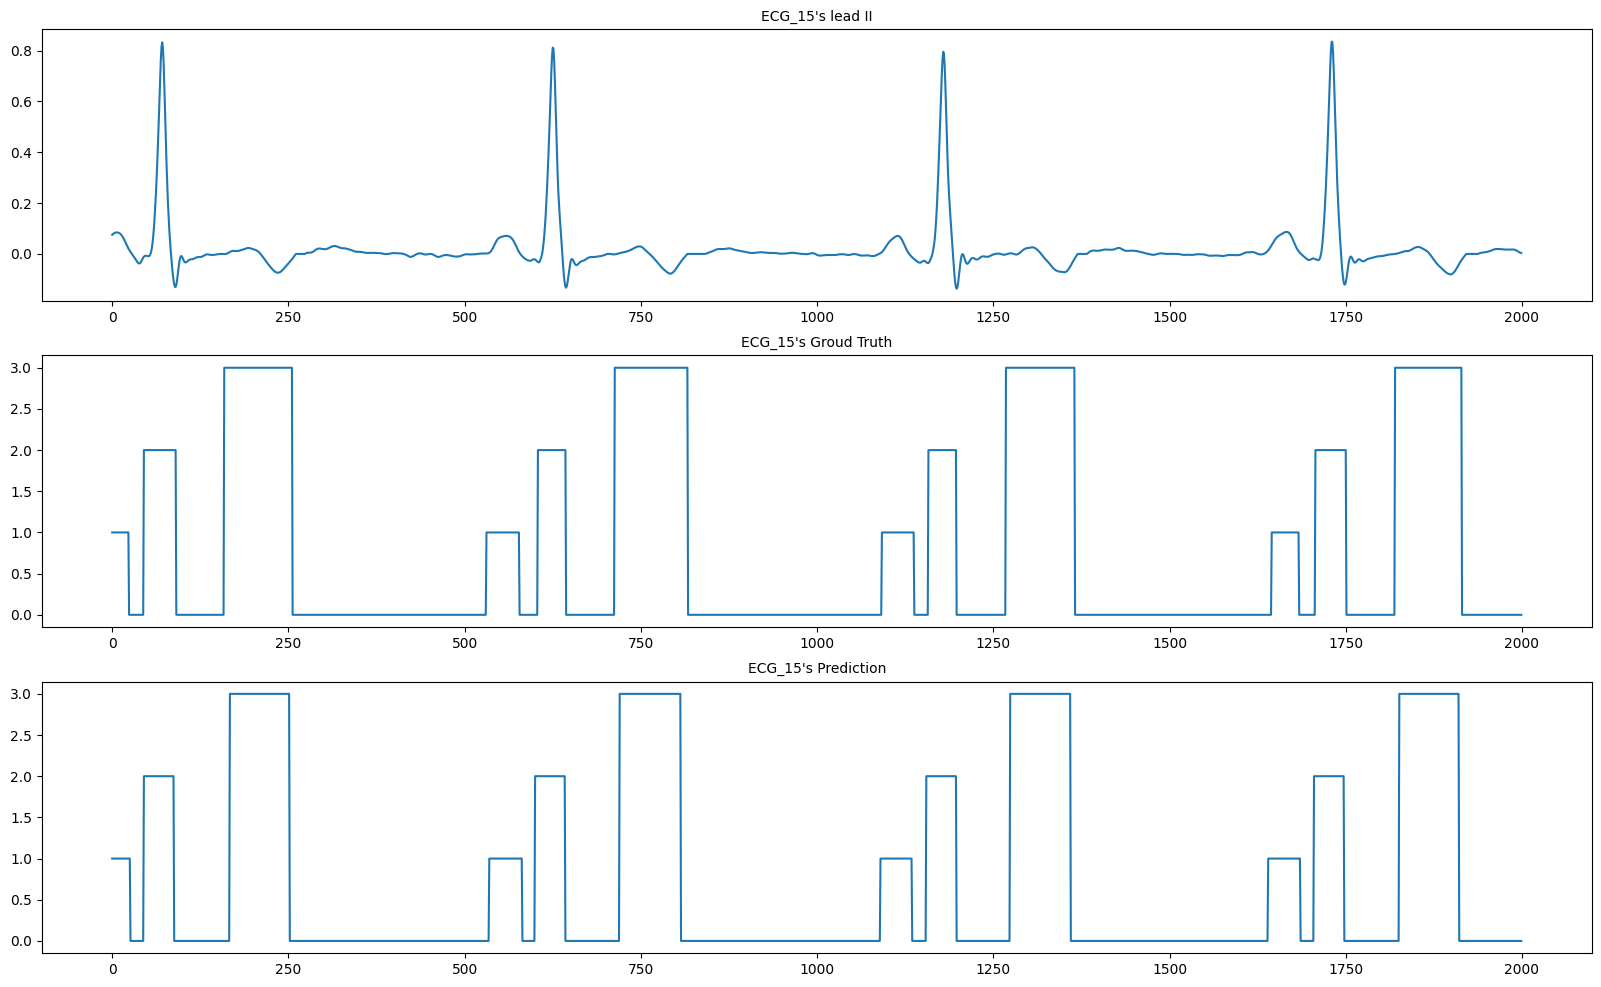

1/1 [==============================] - 0s 26ms/step


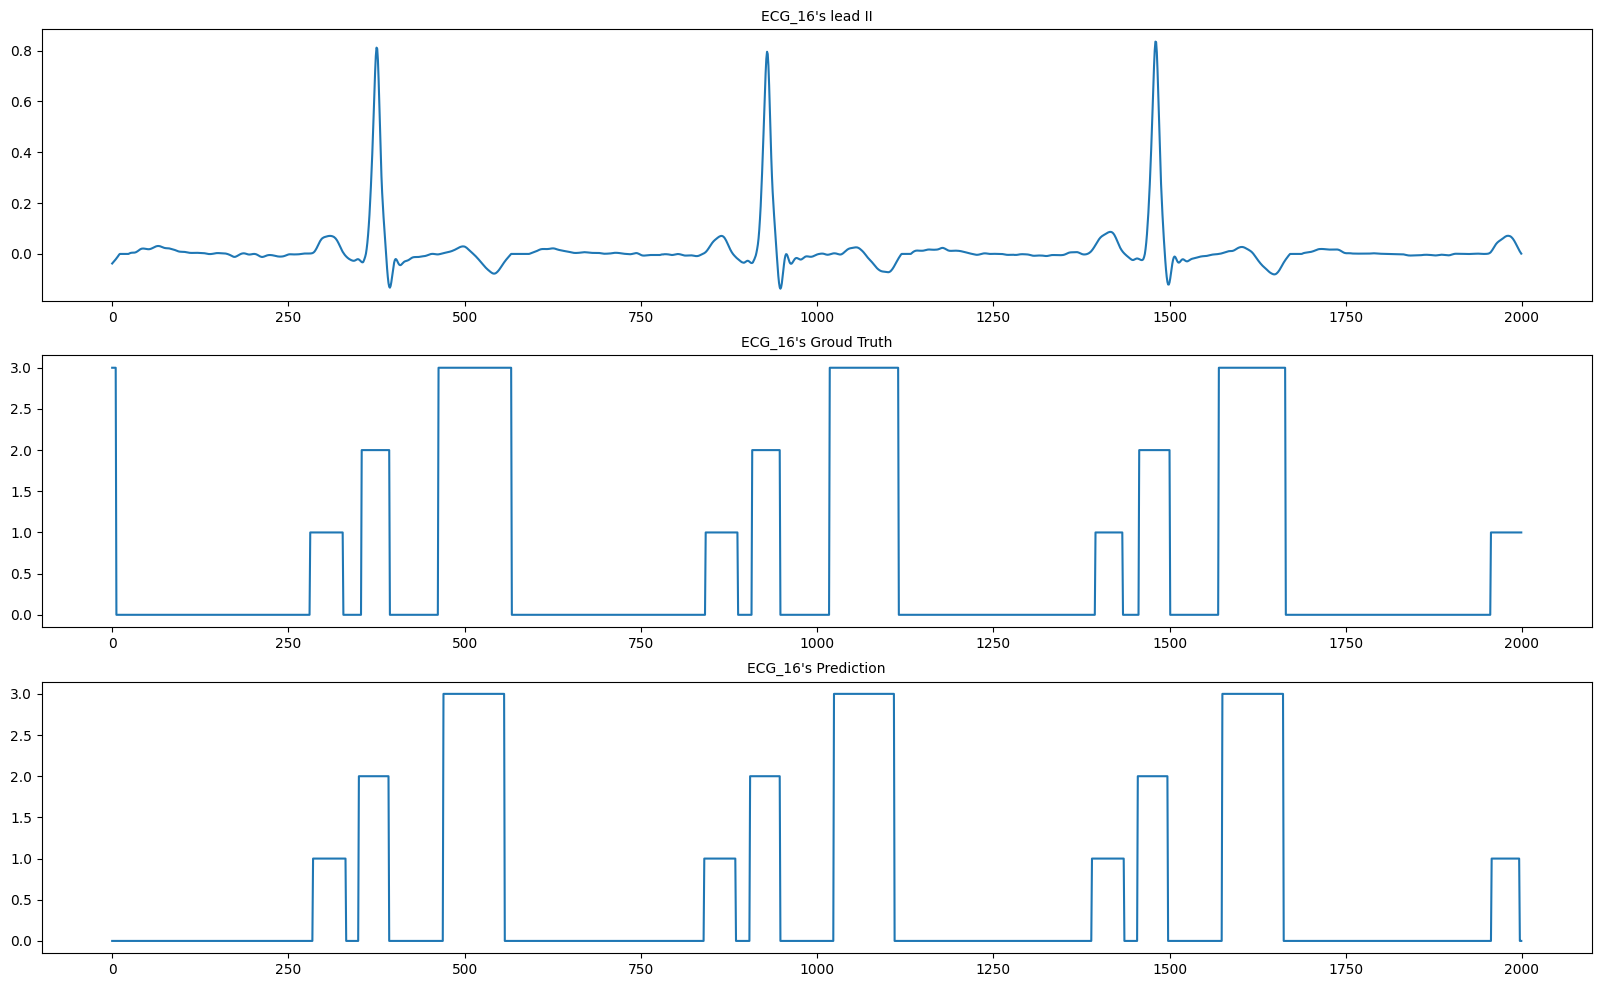

1/1 [==============================] - 0s 29ms/step


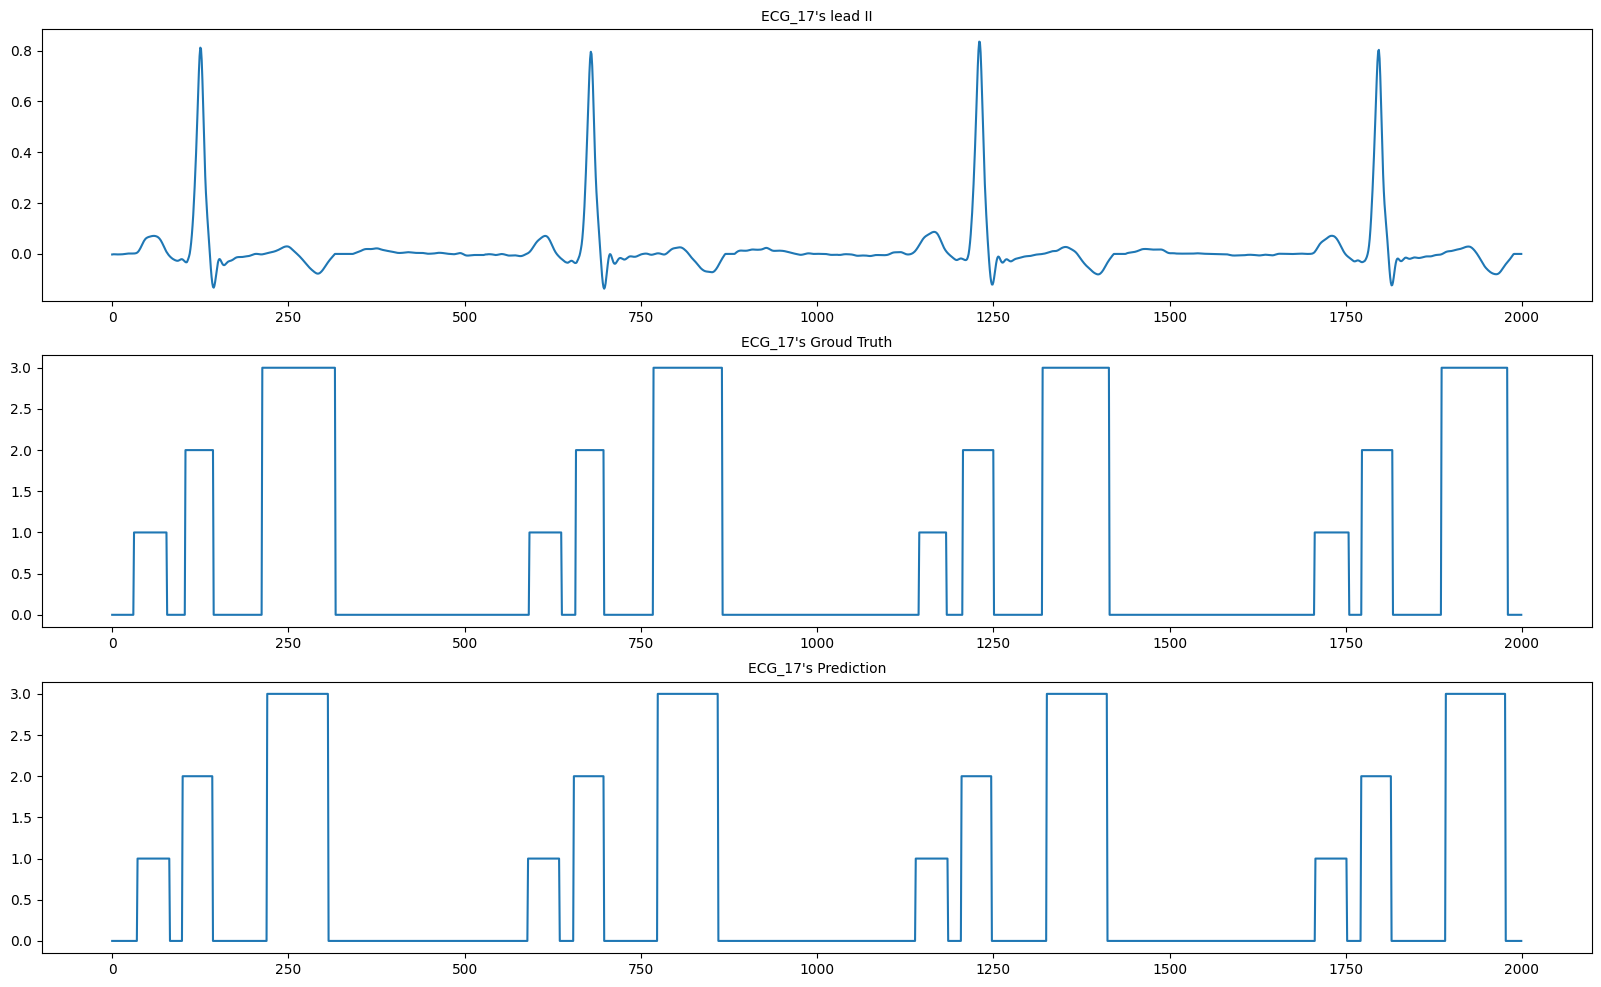

1/1 [==============================] - 0s 31ms/step


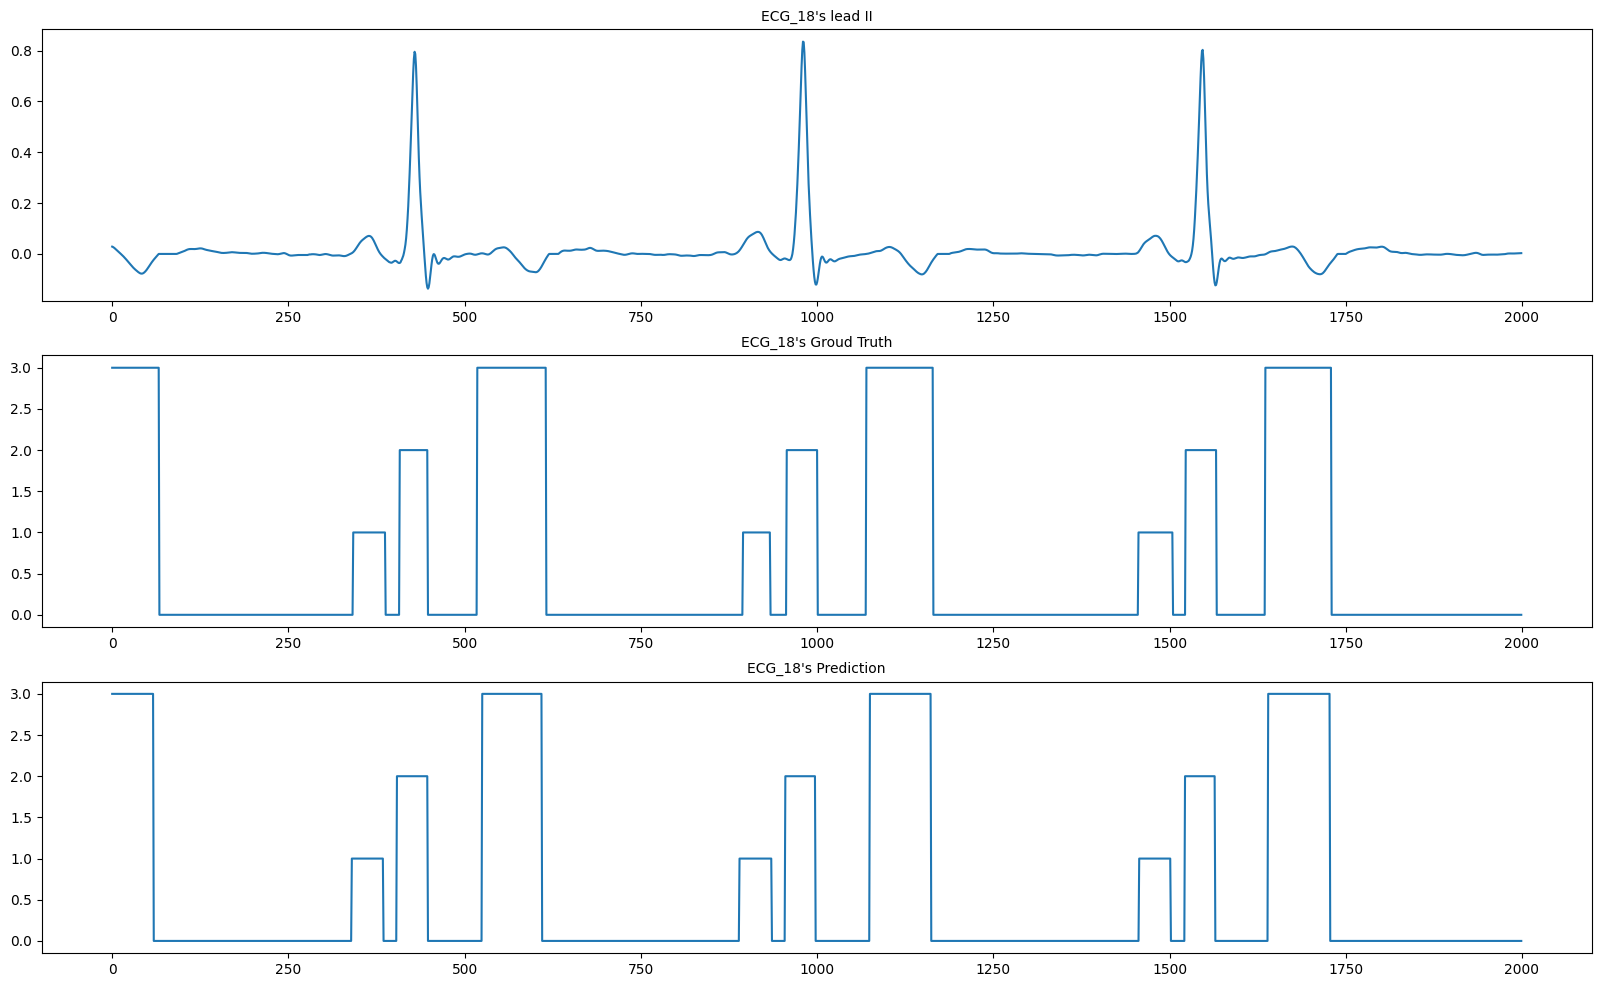

1/1 [==============================] - 0s 25ms/step


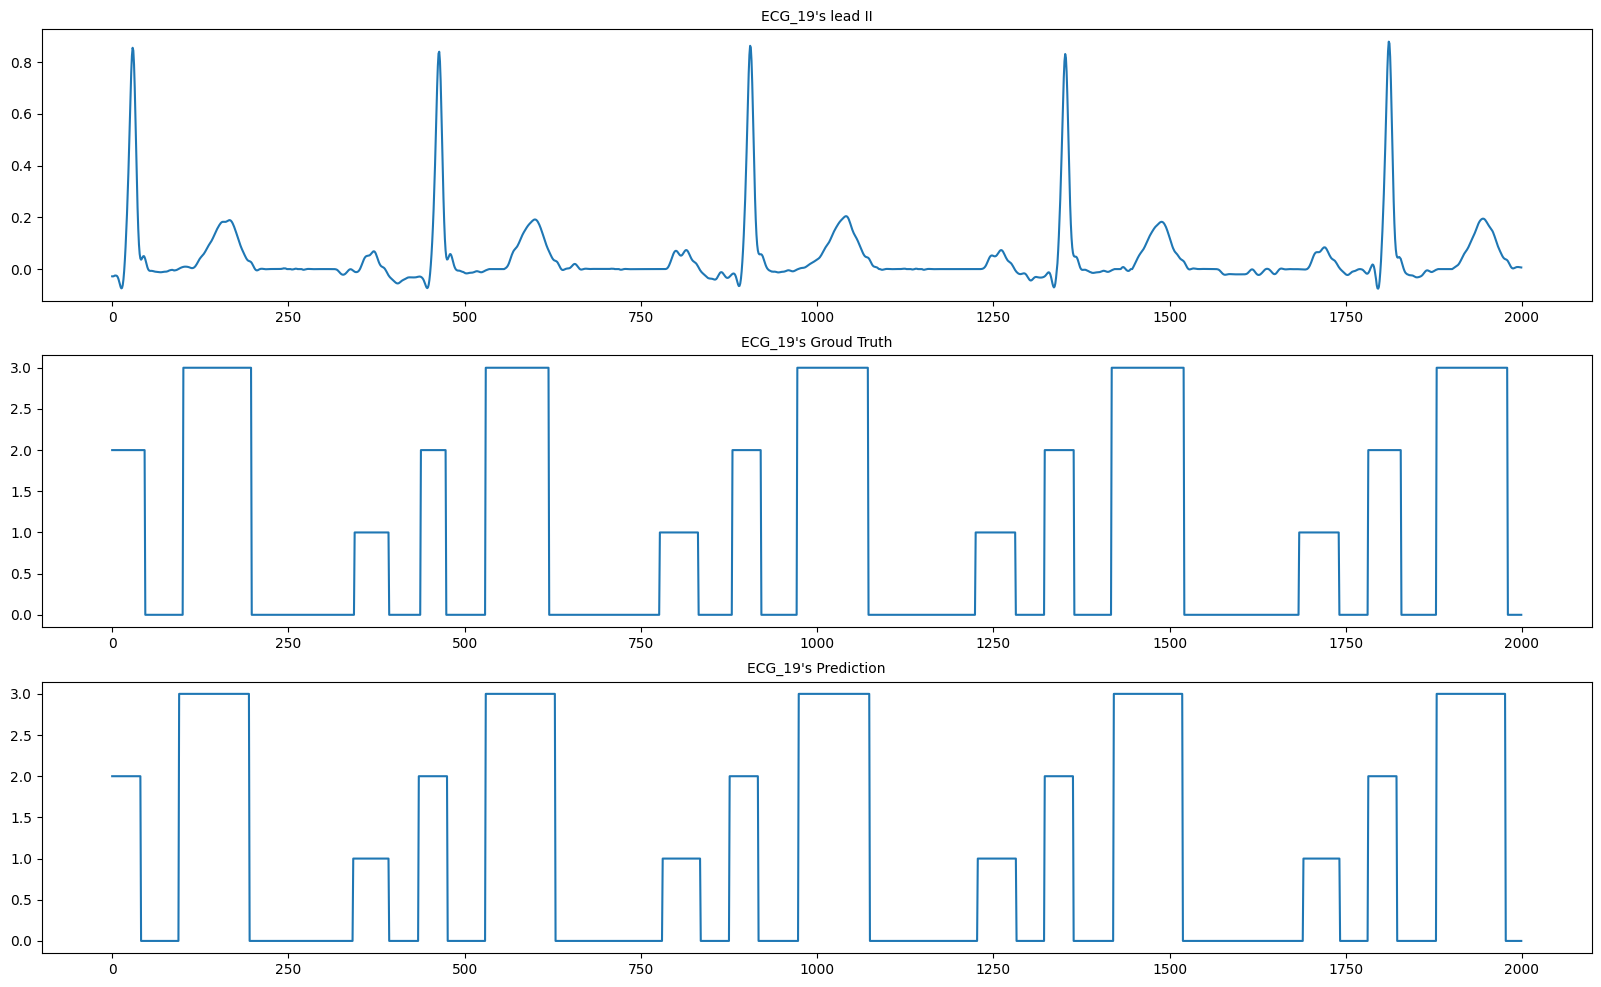

In [ ]:
valid = [np.load("valid_x.npy"), np.load("valid_y.npy")]
print(valid[0].shape)

Predict(test=valid)